# Feature Engineering for Synthetic Finance Anomaly Detection

This notebook demonstrates the process of building an enriched transaction dataset for anomaly detection in personal finance. It merges multiple synthetic financial tables into a single transaction-level DataFrame and computes features that are useful for detecting suspicious or unusual transactions.

## Overview

The feature engineering process involves:
1. **Data Loading**: Loading cleaned datasets from the processed data directory
2. **Table Merging**: Combining multiple financial tables to create enriched transactions
3. **Feature Creation**: Computing derived features for anomaly detection
4. **Data Validation**: Ensuring data quality and consistency

## Dataset Description

The synthetic dataset contains the following tables:
- **transactions** (48,042 rows) - Core transaction data
- **transaction_types** - Transaction type classifications
- **accounts** - Account information with balances
- **account_types** - Account type classifications (Checking, Savings, etc.)
- **account_statuses** - Account status (Active, Inactive, Closed)
- **customers** - Customer demographic information
- **customer_types** - Customer type classifications
- **addresses** - Customer address information
- **branches** - Bank branch information
- **loans** - Loan information linked to accounts
- **loan_statuses** - Loan status classifications

In [107]:
# Data Loading
import os
import glob
import pandas as pd

# Get all CSV files from the processed data directory
raw_data_path = "../data/processed"
csv_files = glob.glob(os.path.join(raw_data_path, "*.csv"))

# Create a dictionary of DataFrames for easy access
dataframes = []
file_names = []

for csv_file in csv_files:
    # Extract filename without extension for reference
    file_name = os.path.basename(csv_file).replace('.csv', '')
    
    # Load CSV into DataFrame
    df = pd.read_csv(csv_file)
    
    # Store DataFrame and filename
    dataframes.append(df)
    file_names.append(file_name)
    
    print(f"Loaded {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")

print(f"\nTotal DataFrames created: {len(dataframes)}")

# Create dictionary for easy access
df_dict = dict(zip(file_names, dataframes))
print(f"\nAvailable DataFrames: {list(df_dict.keys())}")


Loaded accounts_cleaned: 1635 rows, 6 columns
Loaded account_statuses: 3 rows, 2 columns
Loaded account_types: 5 rows, 2 columns
Loaded addresses_cleaned: 1210 rows, 4 columns
Loaded branches_cleaned: 50 rows, 3 columns
Loaded customers_cleaned: 1058 rows, 6 columns
Loaded customer_types: 3 rows, 2 columns
Loaded loans_cleaned: 316 rows, 7 columns
Loaded loan_statuses: 3 rows, 2 columns
Loaded transactions_cleaned: 48042 rows, 8 columns
Loaded transaction_types: 4 rows, 2 columns

Total DataFrames created: 11

Available DataFrames: ['accounts_cleaned', 'account_statuses', 'account_types', 'addresses_cleaned', 'branches_cleaned', 'customers_cleaned', 'customer_types', 'loans_cleaned', 'loan_statuses', 'transactions_cleaned', 'transaction_types']


## Step 1: Data Loading

The first step involves loading all the cleaned datasets from the processed data directory. This includes:

- **Transaction data**: Core transaction records with amounts, dates, and account references
- **Reference tables**: Lookup tables for transaction types, account types, customer types, etc.
- **Account data**: Account balances, types, and status information
- **Customer data**: Customer demographics and contact information
- **Loan data**: Loan information associated with accounts
- **Branch data**: Bank branch information

All datasets are loaded into a dictionary for easy access during the merging process.


In [108]:
# Assign datasets to individual variables for clarity
df_transactions = df_dict['transactions_cleaned']
df_transaction_types = df_dict['transaction_types']
df_account_statuses = df_dict['account_statuses']
df_account_types = df_dict['account_types']
df_accounts = df_dict['accounts_cleaned']
df_branches = df_dict['branches_cleaned']
df_customer_types = df_dict['customer_types']
df_customers = df_dict['customers_cleaned']
df_loan_statuses = df_dict['loan_statuses']
df_loans = df_dict['loans_cleaned']
df_addresses = df_dict['addresses_cleaned']

print("DataFrames assigned successfully!")
print(f"Transaction data shape: {df_transactions.shape}")
print(f"Account data shape: {df_accounts.shape}")
print(f"Customer data shape: {df_customers.shape}")


DataFrames assigned successfully!
Transaction data shape: (48042, 8)
Account data shape: (1635, 6)
Customer data shape: (1058, 6)


## Step 2: Table Merging Strategy

The goal is to create a single enriched transaction DataFrame containing all relevant information about:
- **Origin accounts**: Source account details, customer info, and loan data
- **Destination accounts**: Target account details, customer info, and loan data
- **Transaction context**: Transaction type, branch information, and timing

### Merging Process:

1. **Transaction Types**: Add transaction type names to transactions
2. **Origin Account Details**: Merge account, account type, and account status for origin accounts
3. **Destination Account Details**: Merge account, account type, and account status for destination accounts
4. **Customer Information**: Add customer demographics for both origin and destination
5. **Loan Information**: Aggregate loan data for both origin and destination accounts
6. **Branch Information**: Add branch details for transaction context

This creates a comprehensive dataset where each row represents a transaction with full context about all parties involved.


In [109]:
def build_enriched_transactions(transactions, transaction_types,
                                accounts, account_types, account_statuses,
                                customers, customer_types, addresses,
                                branches, loans, loan_statuses):
    """
    Build an enriched transaction dataset by merging multiple financial tables.
    
    Parameters:
    -----------
    transactions : pd.DataFrame
        Core transaction data
    transaction_types : pd.DataFrame
        Transaction type lookup table
    accounts : pd.DataFrame
        Account information
    account_types : pd.DataFrame
        Account type lookup table
    account_statuses : pd.DataFrame
        Account status lookup table
    customers : pd.DataFrame
        Customer information
    customer_types : pd.DataFrame
        Customer type lookup table
    addresses : pd.DataFrame
        Address information
    branches : pd.DataFrame
        Branch information
    loans : pd.DataFrame
        Loan information
    loan_statuses : pd.DataFrame
        Loan status lookup table
    
    Returns:
    --------
    pd.DataFrame
        Enriched transaction dataset with all relevant information
    """
    
    # === STEP 1: Transaction types ===
    tx = transactions.merge(
        transaction_types,
        on="TransactionTypeID",
        how="left"
    ).rename(columns={"TypeName": "TransactionTypeName"})

    # === STEP 2: Origin account details ===
    tx = tx.merge(
        accounts.add_prefix("Origin_"),
        left_on="AccountOriginID",
        right_on="Origin_AccountID",
        how="left"
    )
    tx = tx.merge(
        account_types.add_prefix("Origin_"),
        left_on="Origin_AccountTypeID",
        right_on="Origin_AccountTypeID",
        how="left"
    ).rename(columns={"Origin_TypeName": "Origin_AccountType"})
    tx = tx.merge(
        account_statuses.add_prefix("Origin_"),
        left_on="Origin_AccountStatusID",
        right_on="Origin_AccountStatusID",
        how="left"
    ).rename(columns={"Origin_StatusName": "Origin_AccountStatus"})

    # === STEP 3: Destination account details ===
    tx = tx.merge(
        accounts.add_prefix("Dest_"),
        left_on="AccountDestinationID",
        right_on="Dest_AccountID",
        how="left"
    )
    tx = tx.merge(
        account_types.add_prefix("Dest_"),
        left_on="Dest_AccountTypeID",
        right_on="Dest_AccountTypeID",
        how="left"
    ).rename(columns={"Dest_TypeName": "Dest_AccountType"})
    tx = tx.merge(
        account_statuses.add_prefix("Dest_"),
        left_on="Dest_AccountStatusID",
        right_on="Dest_AccountStatusID",
        how="left"
    ).rename(columns={"Dest_StatusName": "Dest_AccountStatus"})

    # === STEP 4: Customer info (origin & dest) ===
    customers_full = customers.merge(
        customer_types,
        on="CustomerTypeID",
        how="left"
    ).merge(
        addresses,
        on="AddressID",
        how="left"
    )

    # Origin customer
    tx = tx.merge(
        customers_full.add_prefix("Origin_"),
        left_on="Origin_CustomerID",
        right_on="Origin_CustomerID",
        how="left"
    )

    # Destination customer
    tx = tx.merge(
        customers_full.add_prefix("Dest_"),
        left_on="Dest_CustomerID",
        right_on="Dest_CustomerID",
        how="left"
    )

    # === STEP 5: Branch info ===
    branches_full = branches.merge(
        addresses.add_prefix("Branch_"),
        left_on="AddressID",
        right_on="Branch_AddressID",
        how="left"
    )

    tx = tx.merge(
        branches_full.add_prefix("Branch_"),
        left_on="BranchID",
        right_on="Branch_BranchID",
        how="left"
    )

    # === STEP 6: Loan features ===
    # Aggregate loan metrics per account
    loan_features = loans.groupby("AccountID").agg(
        LoanCount=("LoanID", "count"),
        TotalPrincipal=("PrincipalAmount", "sum"),
        AvgInterestRate=("InterestRate", "mean"),
        MaxInterestRate=("InterestRate", "max"),
        MinInterestRate=("InterestRate", "min")
    ).reset_index()

    # Loan status counts per account
    loan_status_pivot = loans.merge(
        loan_statuses,
        on="LoanStatusID",
        how="left"
    ).groupby(["AccountID", "StatusName"]).size().unstack(fill_value=0).reset_index()

    # Merge loan features for origin accounts
    tx = tx.merge(
        loan_features.add_prefix("Origin_"),
        left_on="Origin_AccountID",
        right_on="Origin_AccountID",
        how="left"
    )

    # Merge loan features for destination accounts
    tx = tx.merge(
        loan_features.add_prefix("Dest_"),
        left_on="Dest_AccountID",
        right_on="Dest_AccountID",
        how="left"
    )

    # Merge loan status counts for origin accounts
    tx = tx.merge(
        loan_status_pivot.add_prefix("Origin_LoanStatus_"),
        left_on="Origin_AccountID",
        right_on="Origin_LoanStatus_AccountID",
        how="left"
    )

    # Merge loan status counts for destination accounts
    tx = tx.merge(
        loan_status_pivot.add_prefix("Dest_LoanStatus_"),
        left_on="Dest_AccountID",
        right_on="Dest_LoanStatus_AccountID",
        how="left"
    )

    return tx

print("Table merging function defined successfully!")


Table merging function defined successfully!


In [110]:
# Execute the table merging process
print("Starting table merging process...")

df_final = build_enriched_transactions(
    df_transactions, df_transaction_types,
    df_accounts, df_account_types, df_account_statuses,
    df_customers, df_customer_types, df_addresses,
    df_branches, df_loans, df_loan_statuses
)

print(f"✅ Merging completed!")
print(f"Final dataset shape: {df_final.shape}")
print(f"Number of columns: {df_final.shape[1]}")
print(f"Number of rows: {df_final.shape[0]}")

# Display basic information about the merged dataset
print("\n📊 Dataset Overview:")
print(f"Memory usage: {df_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Missing values: {df_final.isnull().sum().sum()}")
print(f"Duplicate rows: {df_final.duplicated().sum()}")


Starting table merging process...
✅ Merging completed!
Final dataset shape: (48042, 68)
Number of columns: 68
Number of rows: 48042

📊 Dataset Overview:
Memory usage: 96.47 MB
Missing values: 764446
Duplicate rows: 0


## Step 3: Feature Engineering

After merging all tables, we create derived features that are useful for anomaly detection. These features fall into several categories:

### Feature Categories:

1. **Amount-based Features**: Ratios and relationships between transaction amounts and account balances
2. **Account Status Features**: Flags for inactive or problematic accounts
3. **Customer Demographics**: Age calculations and customer type information
4. **Loan-related Features**: Leverage ratios and loan status indicators
5. **Temporal Features**: Time-based patterns in transactions
6. **Anomaly Flags**: Heuristic flags for potentially suspicious transactions

### Feature Engineering Goals:

- **Detect unusual transaction patterns**: Large transfers, unusual timing, etc.
- **Identify risky accounts**: Inactive accounts, high leverage, etc.
- **Capture customer behavior**: Age-related patterns, customer type differences
- **Enable machine learning**: Create features suitable for anomaly detection algorithms


In [116]:
def compute_transaction_features(df):
    """
    Compute derived features for anomaly detection from the enriched transaction dataset.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Enriched transaction dataset with merged account, customer, and loan information
    
    Returns:
    --------
    pd.DataFrame
        Dataset with additional engineered features
    """
    import numpy as np
    import pandas as pd
    
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    print("🔧 Computing transaction features...")
    
    # === AMOUNT-BASED FEATURES ===
    print("  → Amount-based features")
    
    # Amount ratios (avoid division by zero)
    df['Amount_to_OriginBalance'] = df['Amount'] / df['Origin_Balance'].replace(0, np.nan)
    df['Amount_to_DestBalance'] = df['Amount'] / df['Dest_Balance'].replace(0, np.nan)
    
    # Amount relative to average transaction size
    avg_transaction = df['Amount'].mean()
    df['Amount_to_AvgTransaction'] = df['Amount'] / avg_transaction
    
    # === ACCOUNT STATUS FEATURES ===
    print("  → Account status features")
    
    # Account inactivity flags
    df['Origin_AccountInactive'] = df['Origin_AccountStatus'].isin(['Inactive', 'Closed']).astype(int)
    df['Dest_AccountInactive'] = df['Dest_AccountStatus'].isin(['Inactive', 'Closed']).astype(int)
    
    # Account type flags
    df['Origin_IsChecking'] = (df['Origin_AccountType'] == 'Checking').astype(int)
    df['Dest_IsChecking'] = (df['Dest_AccountType'] == 'Checking').astype(int)
    df['Origin_IsSavings'] = (df['Origin_AccountType'] == 'Savings').astype(int)
    df['Dest_IsSavings'] = (df['Dest_AccountType'] == 'Savings').astype(int)
    
    # === CUSTOMER DEMOGRAPHIC FEATURES ===
    print("  → Customer demographic features")
    
    # Calculate customer ages
    today = pd.Timestamp.today()
    df['Origin_Age'] = (today - pd.to_datetime(df['Origin_DateOfBirth'], errors='coerce')).dt.days // 365
    df['Dest_Age'] = (today - pd.to_datetime(df['Dest_DateOfBirth'], errors='coerce')).dt.days // 365
    
    # Age difference between origin and destination customers
    df['Age_Difference'] = df['Origin_Age'] - df['Dest_Age']
    
    # Customer type flags
    df['Origin_IsIndividual'] = (df['Origin_TypeName'] == 'Individual').astype(int)
    df['Dest_IsIndividual'] = (df['Dest_TypeName'] == 'Individual').astype(int)
    df['Origin_IsBusiness'] = (df['Origin_TypeName'] == 'Small Business').astype(int)
    df['Dest_IsBusiness'] = (df['Dest_TypeName'] == 'Small Business').astype(int)
    
    # === LOAN-RELATED FEATURES ===
    print("  → Loan-related features")
    
    # Loan leverage ratios (debt to balance)
    df['Origin_LoanLeverage'] = df['Origin_TotalPrincipal'] / df['Origin_Balance'].replace(0, np.nan)
    df['Dest_LoanLeverage'] = df['Dest_TotalPrincipal'] / df['Dest_Balance'].replace(0, np.nan)
    
    # Loan count flags
    df['Origin_HasLoans'] = (df['Origin_LoanCount'] > 0).astype(int)
    df['Dest_HasLoans'] = (df['Dest_LoanCount'] > 0).astype(int)
    
    # High interest rate flags (above 10%)
    df['Origin_HighInterest'] = (df['Origin_AvgInterestRate'] > 10).astype(int)
    df['Dest_HighInterest'] = (df['Dest_AvgInterestRate'] > 10).astype(int)
    
    # === TEMPORAL FEATURES ===
    print("  → Temporal features")
    
    # Extract time components
    df['TransactionHour'] = pd.to_datetime(df['TransactionDate']).dt.hour
    df['TransactionWeekday'] = pd.to_datetime(df['TransactionDate']).dt.dayofweek
    df['TransactionMonth'] = pd.to_datetime(df['TransactionDate']).dt.month
    df['TransactionQuarter'] = pd.to_datetime(df['TransactionDate']).dt.quarter
    
    # Time-based flags
    df['IsWeekend'] = (df['TransactionWeekday'] >= 5).astype(int)
    df['IsBusinessHours'] = ((df['TransactionHour'] >= 9) & (df['TransactionHour'] <= 17)).astype(int)
    df['IsNightTime'] = ((df['TransactionHour'] >= 22) | (df['TransactionHour'] <= 6)).astype(int)
    
    # === ANOMALY FLAGS ===
    print("  → Anomaly detection flags")
    
    # Large transfer flags
    df['LargeTransferFlag'] = (df['Amount_to_OriginBalance'] > 0.5).astype(int)
    df['VeryLargeTransferFlag'] = (df['Amount_to_OriginBalance'] > 0.9).astype(int)
    
    # Unusual timing flags
    df['UnusualTimingFlag'] = ((df['IsNightTime'] == 1) | (df['IsWeekend'] == 1)).astype(int)
    
    # High-risk account combinations
    df['HighRiskFlag'] = ((df['Origin_AccountInactive'] == 1) | 
                         (df['Dest_AccountInactive'] == 1) |
                         (df['Origin_LoanLeverage'] > 2) |
                         (df['Dest_LoanLeverage'] > 2)).astype(int)
    
    # Cross-customer type transfers (business to individual, etc.)
    df['CrossTypeTransfer'] = (df['Origin_TypeName'] != df['Dest_TypeName']).astype(int)
    
    print("✅ Feature engineering completed!")
    
    return df

print("Feature engineering function defined successfully!")


Feature engineering function defined successfully!


In [113]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48042 entries, 0 to 48041
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TransactionID                48042 non-null  int64  
 1   AccountOriginID              48042 non-null  int64  
 2   AccountDestinationID         48042 non-null  int64  
 3   TransactionTypeID            48042 non-null  int64  
 4   Amount                       48042 non-null  float64
 5   TransactionDate              48042 non-null  object 
 6   BranchID                     48042 non-null  int64  
 7   Description                  48042 non-null  object 
 8   TransactionTypeName          48042 non-null  object 
 9   Origin_AccountID             47581 non-null  float64
 10  Origin_CustomerID            47581 non-null  float64
 11  Origin_AccountTypeID         47581 non-null  float64
 12  Origin_AccountStatusID       47581 non-null  float64
 13  Origin_Balance  

In [117]:
# Execute feature engineering
print("🚀 Starting feature engineering process...")

df_final_with_features = compute_transaction_features(df_final)

print(f"\n✅ Feature engineering completed!")
print(f"Final dataset shape: {df_final_with_features.shape}")
print(f"Total features: {df_final_with_features.shape[1]}")

# Display feature summary
print(f"\n📈 Feature Summary:")
print(f"Original features: {df_final.shape[1]}")
print(f"New features added: {df_final_with_features.shape[1] - df_final.shape[1]}")
print(f"Total features: {df_final_with_features.shape[1]}")

# Show some sample features
print(f"\n🔍 Sample of new features:")
new_features = [col for col in df_final_with_features.columns if col not in df_final.columns]
print(f"New feature count: {len(new_features)}")
print(f"Sample features: {new_features[:10]}")


🚀 Starting feature engineering process...
🔧 Computing transaction features...
  → Amount-based features
  → Account status features
  → Customer demographic features
  → Loan-related features
  → Temporal features
  → Anomaly detection flags
✅ Feature engineering completed!

✅ Feature engineering completed!
Final dataset shape: (48042, 102)
Total features: 102

📈 Feature Summary:
Original features: 68
New features added: 34
Total features: 102

🔍 Sample of new features:
New feature count: 34
Sample features: ['Amount_to_OriginBalance', 'Amount_to_DestBalance', 'Amount_to_AvgTransaction', 'Origin_AccountInactive', 'Dest_AccountInactive', 'Origin_IsChecking', 'Dest_IsChecking', 'Origin_IsSavings', 'Dest_IsSavings', 'Origin_Age']


## Step 4: Data Validation

After feature engineering, we validate the dataset to ensure data quality and identify any issues that need to be addressed before modeling.

### Validation Checks:

1. **Data Completeness**: Check for missing values and data coverage
2. **Feature Quality**: Validate engineered features for reasonable ranges
3. **Data Consistency**: Ensure logical relationships between features
4. **Memory Usage**: Monitor dataset size and memory requirements
5. **Feature Distribution**: Check for extreme values and outliers


In [118]:
# Data Validation
print("🔍 Performing data validation...")

# Basic dataset information
print(f"\n📊 Dataset Information:")
print(f"Shape: {df_final_with_features.shape}")
print(f"Memory usage: {df_final_with_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Data types: {df_final_with_features.dtypes.value_counts().to_dict()}")

# Missing values analysis
print(f"\n❌ Missing Values Analysis:")
missing_values = df_final_with_features.isnull().sum()
missing_percentage = (missing_values / len(df_final_with_features)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
}).sort_values('Missing_Percentage', ascending=False)

print(f"Columns with missing values: {(missing_values > 0).sum()}")
print(f"Total missing values: {missing_values.sum()}")

if (missing_values > 0).any():
    print(f"\nTop 10 columns with missing values:")
    print(missing_df.head(10).to_string(index=False))

# Feature quality checks
print(f"\n✅ Feature Quality Checks:")

# Check for infinite values
infinite_cols = []
for col in df_final_with_features.select_dtypes(include=[np.number]).columns:
    if np.isinf(df_final_with_features[col]).any():
        infinite_cols.append(col)

if infinite_cols:
    print(f"⚠️  Columns with infinite values: {infinite_cols}")
else:
    print(f"✅ No infinite values found")

# Check for extreme values in key features
print(f"\n🔍 Extreme Values Analysis:")
key_features = ['Amount', 'Amount_to_OriginBalance', 'Amount_to_DestBalance', 
                'Origin_LoanLeverage', 'Dest_LoanLeverage']

for feature in key_features:
    if feature in df_final_with_features.columns:
        q99 = df_final_with_features[feature].quantile(0.99)
        q01 = df_final_with_features[feature].quantile(0.01)
        print(f"{feature}: 1st percentile = {q01:.2f}, 99th percentile = {q99:.2f}")

# Check feature ranges
print(f"\n📈 Feature Ranges:")
numeric_features = df_final_with_features.select_dtypes(include=[np.number]).columns
print(f"Numeric features: {len(numeric_features)}")

# Sample of feature statistics
print(f"\n📋 Sample Feature Statistics:")
sample_features = ['Amount', 'TransactionHour', 'Origin_Age', 'Dest_Age', 'LargeTransferFlag']
available_features = [f for f in sample_features if f in df_final_with_features.columns]

if available_features:
    print(df_final_with_features[available_features].describe().round(2))

print(f"\n✅ Data validation completed!")


🔍 Performing data validation...

📊 Dataset Information:
Shape: (48042, 102)
Memory usage: 108.19 MB
Data types: {dtype('float64'): 41, dtype('int64'): 30, dtype('O'): 27, dtype('int32'): 4}

❌ Missing Values Analysis:
Columns with missing values: 59
Total missing values: 854449

Top 10 columns with missing values:
                   Column  Missing_Count  Missing_Percentage
     Dest_AvgInterestRate          39553           82.330045
     Dest_MaxInterestRate          39553           82.330045
     Dest_MinInterestRate          39553           82.330045
 Dest_LoanStatus_Paid Off          39553           82.330045
Dest_LoanStatus_AccountID          39553           82.330045
   Dest_LoanStatus_Active          39553           82.330045
  Dest_LoanStatus_Overdue          39553           82.330045
      Dest_TotalPrincipal          39553           82.330045
        Dest_LoanLeverage          39553           82.330045
           Dest_LoanCount          39553           82.330045

✅ Feature Qu

## Step 5: Save Processed Data

The final step is to save the enriched and feature-engineered dataset for use in machine learning models.

### Output Files:

1. **Enriched Transactions**: Complete dataset with all merged information
2. **Feature Summary**: Documentation of all engineered features
3. **Data Quality Report**: Summary of validation results

### Next Steps:

- **Model Training**: Use this dataset for anomaly detection model training
- **Feature Selection**: Identify the most important features for the model
- **Model Evaluation**: Test different algorithms and hyperparameters
- **Production Deployment**: Integrate into the MLOps pipeline


In [ ]:
# Save the processed data
print("💾 Saving processed data...")

# Create output directory if it doesn't exist
import os
output_dir = "../data/processed"
os.makedirs(output_dir, exist_ok=True)

# Save the enriched dataset
output_file = os.path.join(output_dir, "enriched_transactions_with_features.csv")
df_final_with_features.to_csv(output_file, index=False)

print(f"✅ Dataset saved to: {output_file}")
print(f"File size: {os.path.getsize(output_file) / 1024**2:.2f} MB")

# Create feature summary
feature_summary = {
    'Total_Features': len(df_final_with_features.columns),
    'Original_Features': len(df_final.shape[1]),
    'Engineered_Features': len(df_final_with_features.columns) - df_final.shape[1],
    'Numeric_Features': len(df_final_with_features.select_dtypes(include=[np.number]).columns),
    'Categorical_Features': len(df_final_with_features.select_dtypes(include=['object']).columns),
    'Boolean_Features': len(df_final_with_features.select_dtypes(include=['bool']).columns),
    'Missing_Values': df_final_with_features.isnull().sum().sum(),
    'Duplicate_Rows': df_final_with_features.duplicated().sum()
}

print(f"\n📋 Feature Summary:")
for key, value in feature_summary.items():
    print(f"{key}: {value}")

# Save feature summary
feature_summary_file = os.path.join(output_dir, "feature_summary.txt")
with open(feature_summary_file, 'w') as f:
    f.write("Feature Engineering Summary\n")
    f.write("=" * 50 + "\n\n")
    for key, value in feature_summary.items():
        f.write(f"{key}: {value}\n")
    
    f.write(f"\nFeature List:\n")
    f.write("-" * 20 + "\n")
    for i, col in enumerate(df_final_with_features.columns, 1):
        f.write(f"{i:3d}. {col}\n")

print(f"✅ Feature summary saved to: {feature_summary_file}")

print(f"\n🎉 Feature engineering pipeline completed successfully!")
print(f"📊 Final dataset: {df_final_with_features.shape[0]} rows × {df_final_with_features.shape[1]} columns")
print(f"💾 Data saved to: {output_file}")
print(f"📋 Summary saved to: {feature_summary_file}")


---

# Exploratory Data Analysis (EDA)

After completing the feature engineering process, we perform exploratory data analysis to understand the characteristics of our enriched dataset and identify patterns that could be useful for anomaly detection.

## EDA Objectives

1. **Data Overview**: Understand the basic structure and quality of the dataset
2. **Feature Analysis**: Examine the distribution and characteristics of engineered features
3. **Pattern Discovery**: Identify trends and patterns in transaction behavior
4. **Anomaly Indicators**: Look for potential anomalies in the data
5. **Feature Relationships**: Understand correlations between different features


In [119]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("📊 EDA libraries imported successfully!")


📊 EDA libraries imported successfully!


## Step 1: Basic Data Overview

Let's start by examining the basic structure and quality of our enriched dataset.


In [120]:
# Basic dataset information
print("📋 Dataset Overview:")
print(f"Shape: {df_final_with_features.shape}")
print(f"Memory usage: {df_final_with_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Data types: {df_final_with_features.dtypes.value_counts().to_dict()}")

# Display first few rows
print(f"\n🔍 First 5 rows:")
df_final_with_features.head()


📋 Dataset Overview:
Shape: (48042, 102)
Memory usage: 108.19 MB
Data types: {dtype('float64'): 41, dtype('int64'): 30, dtype('O'): 27, dtype('int32'): 4}

🔍 First 5 rows:


,TransactionID,AccountOriginID,AccountDestinationID,TransactionTypeID,Amount,TransactionDate,BranchID,Description,TransactionTypeName,Origin_AccountID,Origin_CustomerID,Origin_AccountTypeID,Origin_AccountStatusID,Origin_Balance,Origin_OpeningDate,Origin_AccountType,Origin_AccountStatus,Dest_AccountID,Dest_CustomerID,Dest_AccountTypeID,Dest_AccountStatusID,Dest_Balance,Dest_OpeningDate,Dest_AccountType,Dest_AccountStatus,Origin_FirstName,Origin_LastName,Origin_DateOfBirth,Origin_AddressID,Origin_CustomerTypeID,Origin_TypeName,Origin_Street,Origin_City,Origin_Country,Dest_FirstName,Dest_LastName,Dest_DateOfBirth,Dest_AddressID,Dest_CustomerTypeID,Dest_TypeName,Dest_Street,Dest_City,Dest_Country,Branch_BranchID,Branch_BranchName,Branch_AddressID,Branch_Branch_AddressID,Branch_Branch_Street,Branch_Branch_City,Branch_Branch_Country,Origin_LoanCount,Origin_TotalPrincipal,Origin_AvgInterestRate,Origin_MaxInterestRate,Origin_MinInterestRate,Dest_LoanCount,Dest_TotalPrincipal,Dest_AvgInterestRate,Dest_MaxInterestRate,Dest_MinInterestRate,Origin_LoanStatus_AccountID,Origin_LoanStatus_Active,Origin_LoanStatus_Overdue,Origin_LoanStatus_Paid Off,Dest_LoanStatus_AccountID,Dest_LoanStatus_Active,Dest_LoanStatus_Overdue,Dest_LoanStatus_Paid Off,Amount_to_OriginBalance,Amount_to_DestBalance,Amount_to_AvgTransaction,Origin_AccountInactive,Dest_AccountInactive,Origin_IsChecking,Dest_IsChecking,Origin_IsSavings,Dest_IsSavings,Origin_Age,Dest_Age,Age_Difference,Origin_IsIndividual,Dest_IsIndividual,Origin_IsBusiness,Dest_IsBusiness,Origin_LoanLeverage,Dest_LoanLeverage,Origin_HasLoans,Dest_HasLoans,Origin_HighInterest,Dest_HighInterest,TransactionHour,TransactionWeekday,TransactionMonth,TransactionQuarter,IsWeekend,IsBusinessHours,IsNightTime,LargeTransferFlag,VeryLargeTransferFlag,UnusualTimingFlag,HighRiskFlag,CrossTypeTransfer
0,3000000,201241,200847,3,2984.02,2023-12-29 10:00:00.000000,26,Transaction 0,Transfer,201241.0,10184.0,5.0,1.0,55292.55,2000-01-01,Youth,Active,200847.0,10351.0,2.0,2.0,54095.48,2021-01-30,Savings,Inactive,Tinisha,Velez,1963-07-30,774.0,2.0,Small Business,Edgemont,Leawood,United States,Valene,Perry,1967-06-18,524.0,1.0,Individual,Revere,Bangor,United States,26,Branch 26,49,49,Catherine,Lompoc,United States,1.0,52255.85,0.12830,0.1283,0.1283,NaN,NaN,NaN,NaN,NaN,201241.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,0.053968,0.055162,1.191976,0,1,0,0,0,1,62.0,58.0,4.0,0,1,1,0,0.945079,NaN,1,0,0,0,10,4,12,4,0,1,0,0,0,0,1,1
1,3000001,201103,200262,3,4713.48,2023-05-12 02:00:00.000000,23,Transaction 1,Transfer,201103.0,10333.0,1.0,1.0,22940.53,2021-12-02,Checking,Active,200262.0,10850.0,4.0,1.0,70727.24,2019-09-05,Business,Active,Unknown,Rush,1973-07-17,540.0,3.0,Large Enterprise,Quane,Gilroy,United States,Laine,Montgomery,1989-08-28,1115.0,3.0,Large Enterprise,Miraloma,Concord,United States,23,Branch 23,673,673,Clyde,San Marcos,United States,2.0,146020.58,0.07795,0.0793,0.0766,1.0,59673.83,0.1411,0.1411,0.1411,201103.0,2.0,0.0,0.0,200262.0,1.0,0.0,0.0,0.205465,0.066643,1.882814,0,0,1,0,0,0,52.0,36.0,16.0,0,0,0,0,6.365179,0.843718,1,1,0,0,2,4,5,2,0,0,1,0,0,1,1,0
2,3000002,201563,200589,3,1600.23,2020-07-14 17:00:00.000000,5,Transaction 2,Transfer,201563.0,10586.0,4.0,1.0,62435.08,2019-07-14,Business,Active,200589.0,10468.0,5.0,2.0,90061.73,2019-12-19,Youth,Inactive,Troy,Hatfield,1976-11-02,1011.0,2.0,Small Business,Carson,Unknown,United States,Earnest,West,1983-03-14,957.0,1.0,Individual,Eighth,Hobbs,United States,5,Branch 5,796,796,Getz,Steubenville,United States,1.0,22288.38,0.09690,0.0969,0.0969,NaN,NaN,NaN,NaN,NaN,201563.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.025630,0.017768,0.639217,0,1,0,0,0,0,48.0,42.0,6.0,0,1,1,0,0.356985,NaN,1,0,0,0,17,1,7,3,0,1,0,0,0,0,1,1
3,3000003,200512,200404,1,4279.61,2023-09-09 07:00:00.000000,36,Transaction 3,Deposit,200512.0,10972.0,4.0,1.0,12739.44,2021-06-21,Business,Active,200404.0,10229.0,3.0,1.0,32623.75,2021-12-24,Payroll,Active,My,Herring,1974-09-08,192.0,3.0,Large Enterprise,Lick,Walla Walla,United States,My

In [ ]:
# Dataset information and data types
print("📊 Dataset Information:")
df_final_with_features.info()

print(f"\n📈 Basic Statistics:")
df_final_with_features.describe()


## Step 2: Univariate Analysis

Let's examine the distribution of key features to understand their characteristics and identify potential outliers.


In [ ]:
# Transaction Amount Analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(x=df_final_with_features['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount ($)')

plt.subplot(1, 3, 2)
sns.boxplot(x=df_final_with_features['Amount'])
plt.title('Box Plot of Transaction Amounts')
plt.xlabel('Amount ($)')

plt.subplot(1, 3, 3)
# Log scale for better visualization
sns.histplot(x=np.log1p(df_final_with_features['Amount']), bins=50, kde=True)
plt.title('Distribution of Log(Amount + 1)')
plt.xlabel('Log(Amount + 1)')

plt.tight_layout()
plt.show()

# Amount statistics
print("💰 Transaction Amount Statistics:")
print(f"Mean: ${df_final_with_features['Amount'].mean():.2f}")
print(f"Median: ${df_final_with_features['Amount'].median():.2f}")
print(f"Std: ${df_final_with_features['Amount'].std():.2f}")
print(f"Min: ${df_final_with_features['Amount'].min():.2f}")
print(f"Max: ${df_final_with_features['Amount'].max():.2f}")
print(f"95th percentile: ${df_final_with_features['Amount'].quantile(0.95):.2f}")
print(f"99th percentile: ${df_final_with_features['Amount'].quantile(0.99):.2f}")


In [ ]:
# Account Balance Analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(x=df_final_with_features['Origin_Balance'], bins=50, kde=True)
plt.title('Distribution of Origin Account Balances')
plt.xlabel('Balance ($)')

plt.subplot(1, 3, 2)
sns.histplot(x=df_final_with_features['Dest_Balance'], bins=50, kde=True)
plt.title('Distribution of Destination Account Balances')
plt.xlabel('Balance ($)')

plt.subplot(1, 3, 3)
# Amount to balance ratios
sns.histplot(x=df_final_with_features['Amount_to_OriginBalance'], bins=50, kde=True)
plt.title('Distribution of Amount to Origin Balance Ratio')
plt.xlabel('Amount/Balance Ratio')

plt.tight_layout()
plt.show()

# Balance statistics
print("🏦 Account Balance Statistics:")
print(f"Origin Balance - Mean: ${df_final_with_features['Origin_Balance'].mean():.2f}")
print(f"Origin Balance - Median: ${df_final_with_features['Origin_Balance'].median():.2f}")
print(f"Dest Balance - Mean: ${df_final_with_features['Dest_Balance'].mean():.2f}")
print(f"Dest Balance - Median: ${df_final_with_features['Dest_Balance'].median():.2f}")
print(f"Amount to Origin Balance - Mean: {df_final_with_features['Amount_to_OriginBalance'].mean():.3f}")
print(f"Amount to Origin Balance - 95th percentile: {df_final_with_features['Amount_to_OriginBalance'].quantile(0.95):.3f}")


In [ ]:
# Customer Age Analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(x=df_final_with_features['Origin_Age'], bins=30, kde=True)
plt.title('Distribution of Origin Customer Ages')
plt.xlabel('Age (years)')

plt.subplot(1, 3, 2)
sns.histplot(x=df_final_with_features['Dest_Age'], bins=30, kde=True)
plt.title('Distribution of Destination Customer Ages')
plt.xlabel('Age (years)')

plt.subplot(1, 3, 3)
sns.histplot(x=df_final_with_features['Age_Difference'], bins=30, kde=True)
plt.title('Distribution of Age Differences')
plt.xlabel('Age Difference (years)')

plt.tight_layout()
plt.show()

# Age statistics
print("👥 Customer Age Statistics:")
print(f"Origin Age - Mean: {df_final_with_features['Origin_Age'].mean():.1f} years")
print(f"Origin Age - Median: {df_final_with_features['Origin_Age'].median():.1f} years")
print(f"Dest Age - Mean: {df_final_with_features['Dest_Age'].mean():.1f} years")
print(f"Dest Age - Median: {df_final_with_features['Dest_Age'].median():.1f} years")
print(f"Age Difference - Mean: {df_final_with_features['Age_Difference'].mean():.1f} years")


## Step 3: Categorical Feature Analysis

Let's examine the distribution of categorical features and their relationship with transaction amounts.


In [ ]:
# Transaction Type Analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_final_with_features['TransactionTypeName'].value_counts().plot(kind='bar')
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(x='TransactionTypeName', y='Amount', data=df_final_with_features)
plt.title('Transaction Amount by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
# Average amount by transaction type
avg_amount_by_type = df_final_with_features.groupby('TransactionTypeName')['Amount'].mean().sort_values(ascending=False)
avg_amount_by_type.plot(kind='bar')
plt.title('Average Amount by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Average Amount ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Transaction type statistics
print("💳 Transaction Type Statistics:")
print(df_final_with_features['TransactionTypeName'].value_counts())
print(f"\nAverage amounts by type:")
print(avg_amount_by_type.round(2))


In [ ]:
# Customer Type Analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_final_with_features['Origin_CustomerType'].value_counts().plot(kind='bar')
plt.title('Distribution of Origin Customer Types')
plt.xlabel('Customer Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(x='Origin_CustomerType', y='Amount', data=df_final_with_features)
plt.title('Transaction Amount by Origin Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(x='Dest_CustomerType', y='Amount', data=df_final_with_features)
plt.title('Transaction Amount by Destination Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Customer type statistics
print("👤 Customer Type Statistics:")
print("Origin Customer Types:")
print(df_final_with_features['Origin_CustomerType'].value_counts())
print("\nDestination Customer Types:")
print(df_final_with_features['Dest_CustomerType'].value_counts())


## Step 4: Temporal Analysis

Let's examine time-based patterns in the transaction data.


In [ ]:
# Temporal Analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_final_with_features['TransactionHour'], bins=24)
plt.title('Transaction Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.histplot(df_final_with_features['TransactionWeekday'], bins=7)
plt.title('Transaction Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
# Average amount by hour
hourly_avg = df_final_with_features.groupby('TransactionHour')['Amount'].mean()
hourly_avg.plot(kind='line', marker='o')
plt.title('Average Transaction Amount by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Amount ($)')

plt.tight_layout()
plt.show()

# Temporal statistics
print("⏰ Temporal Statistics:")
print(f"Transactions per hour (mean): {df_final_with_features['TransactionHour'].value_counts().mean():.1f}")
print(f"Peak hour: {df_final_with_features['TransactionHour'].mode()[0]}")
print(f"Weekend transactions: {df_final_with_features['IsWeekend'].sum()} ({df_final_with_features['IsWeekend'].mean()*100:.1f}%)")
print(f"Night time transactions: {df_final_with_features['IsNightTime'].sum()} ({df_final_with_features['IsNightTime'].mean()*100:.1f}%)")
print(f"Business hours transactions: {df_final_with_features['IsBusinessHours'].sum()} ({df_final_with_features['IsBusinessHours'].mean()*100:.1f}%)")


## Step 5: Bivariate Analysis

Let's examine relationships between different features to identify patterns and potential anomalies.


In [ ]:
# Amount vs Balance Relationships
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=df_final_with_features['Amount_to_DestBalance'], y='Amount', data=df_final_with_features, alpha=0.6)
plt.title('Amount vs Amount to Destination Balance Ratio')
plt.xlabel('Amount to Dest Balance Ratio')
plt.ylabel('Amount ($)')

plt.subplot(1, 3, 2)
sns.scatterplot(x='Amount_to_OriginBalance', y='Amount', data=df_final_with_features, alpha=0.6)
plt.title('Amount vs Amount to Origin Balance Ratio')
plt.xlabel('Amount to Origin Balance Ratio')
plt.ylabel('Amount ($)')

plt.subplot(1, 3, 3)
sns.scatterplot(x=df_final_with_features['Origin_Balance'], y=df_final_with_features['Origin_LoanLeverage'], alpha=0.6)
plt.title('Origin Balance vs Loan Leverage')
plt.xlabel('Origin Balance ($)')
plt.ylabel('Loan Leverage')

plt.tight_layout()
plt.show()

# Correlation analysis
print("🔗 Correlation Analysis:")
correlation_features = ['Amount', 'Amount_to_OriginBalance', 'Amount_to_DestBalance', 
                       'Origin_Balance', 'Dest_Balance', 'Origin_Age', 'Dest_Age',
                       'Origin_LoanLeverage', 'Dest_LoanLeverage']

correlation_matrix = df_final_with_features[correlation_features].corr()
print(correlation_matrix.round(3))


In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Anomaly Flag Analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_final_with_features['LargeTransferFlag'].value_counts().plot(kind='bar')
plt.title('Large Transfer Flag Distribution')
plt.xlabel('Large Transfer Flag')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
df_final_with_features['HighRiskFlag'].value_counts().plot(kind='bar')
plt.title('High Risk Flag Distribution')
plt.xlabel('High Risk Flag')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
df_final_with_features['CrossTypeTransfer'].value_counts().plot(kind='bar')
plt.title('Cross Type Transfer Flag Distribution')
plt.xlabel('Cross Type Transfer Flag')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Anomaly flag statistics
print("🚨 Anomaly Flag Statistics:")
print(f"Large Transfer Flag: {df_final_with_features['LargeTransferFlag'].sum()} ({df_final_with_features['LargeTransferFlag'].mean()*100:.1f}%)")
print(f"Very Large Transfer Flag: {df_final_with_features['VeryLargeTransferFlag'].sum()} ({df_final_with_features['VeryLargeTransferFlag'].mean()*100:.1f}%)")
print(f"High Risk Flag: {df_final_with_features['HighRiskFlag'].sum()} ({df_final_with_features['HighRiskFlag'].mean()*100:.1f}%)")
print(f"Cross Type Transfer: {df_final_with_features['CrossTypeTransfer'].sum()} ({df_final_with_features['CrossTypeTransfer'].mean()*100:.1f}%)")
print(f"Unusual Timing Flag: {df_final_with_features['UnusualTimingFlag'].sum()} ({df_final_with_features['UnusualTimingFlag'].mean()*100:.1f}%)")


## Step 6: Feature Correlation & Redundancy Analysis

Let's examine feature correlations to identify redundant features and understand feature relationships.


In [ ]:
# Feature Correlation Analysis
print("🔍 Feature Correlation Analysis:")

# Select numeric features for correlation analysis
numeric_features = df_final_with_features.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns and other non-predictive features
exclude_features = ['AccountOriginID', 'AccountDestinationID', 'Origin_AccountID', 'Dest_AccountID',
                   'Origin_CustomerID', 'Dest_CustomerID', 'BranchID', 'TransactionID']

numeric_features = [f for f in numeric_features if f not in exclude_features]

print(f"Analyzing {len(numeric_features)} numeric features...")

# Calculate correlation matrix
correlation_matrix_full = df_final_with_features[numeric_features].corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix_full.columns)):
    for j in range(i+1, len(correlation_matrix_full.columns)):
        corr_value = correlation_matrix_full.iloc[i, j]
        if abs(corr_value) > 0.8:  # High correlation threshold
            high_corr_pairs.append({
                'Feature1': correlation_matrix_full.columns[i],
                'Feature2': correlation_matrix_full.columns[j],
                'Correlation': corr_value
            })

if high_corr_pairs:
    print(f"\n⚠️  High correlation pairs (|r| > 0.8):")
    for pair in high_corr_pairs:
        print(f"  {pair['Feature1']} ↔ {pair['Feature2']}: {pair['Correlation']:.3f}")
else:
    print(f"\n✅ No highly correlated feature pairs found (|r| > 0.8)")

# Feature importance based on variance
feature_variance = df_final_with_features[numeric_features].var().sort_values(ascending=False)
print(f"\n📊 Top 10 features by variance:")
print(feature_variance.head(10).round(4))

# Missing value analysis
missing_analysis = df_final_with_features[numeric_features].isnull().sum().sort_values(ascending=False)
missing_features = missing_analysis[missing_analysis > 0]

if len(missing_features) > 0:
    print(f"\n❌ Features with missing values:")
    for feature, count in missing_features.items():
        percentage = (count / len(df_final_with_features)) * 100
        print(f"  {feature}: {count} ({percentage:.1f}%)")
else:
    print(f"\n✅ No missing values in numeric features")


## Step 7: EDA Summary and Insights

Let's summarize our findings from the exploratory data analysis.


In [ ]:
# EDA Summary
print("📋 EDA Summary and Insights")
print("=" * 50)

print(f"\n📊 Dataset Overview:")
print(f"  • Total transactions: {len(df_final_with_features):,}")
print(f"  • Total features: {len(df_final_with_features.columns)}")
print(f"  • Memory usage: {df_final_with_features.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\n💰 Transaction Amount Insights:")
print(f"  • Average transaction: ${df_final_with_features['Amount'].mean():.2f}")
print(f"  • Median transaction: ${df_final_with_features['Amount'].median():.2f}")
print(f"  • 95th percentile: ${df_final_with_features['Amount'].quantile(0.95):.2f}")
print(f"  • 99th percentile: ${df_final_with_features['Amount'].quantile(0.99):.2f}")

print(f"\n🏦 Account Balance Insights:")
print(f"  • Average origin balance: ${df_final_with_features['Origin_Balance'].mean():.2f}")
print(f"  • Average destination balance: ${df_final_with_features['Dest_Balance'].mean():.2f}")
print(f"  • Large transfers (>50% of balance): {df_final_with_features['LargeTransferFlag'].sum():,} ({df_final_with_features['LargeTransferFlag'].mean()*100:.1f}%)")

print(f"\n👥 Customer Insights:")
print(f"  • Average origin customer age: {df_final_with_features['Origin_Age'].mean():.1f} years")
print(f"  • Average destination customer age: {df_final_with_features['Dest_Age'].mean():.1f} years")
print(f"  • Cross-type transfers: {df_final_with_features['CrossTypeTransfer'].sum():,} ({df_final_with_features['CrossTypeTransfer'].mean()*100:.1f}%)")

print(f"\n⏰ Temporal Insights:")
print(f"  • Peak transaction hour: {df_final_with_features['TransactionHour'].mode()[0]}")
print(f"  • Weekend transactions: {df_final_with_features['IsWeekend'].sum():,} ({df_final_with_features['IsWeekend'].mean()*100:.1f}%)")
print(f"  • Night time transactions: {df_final_with_features['IsNightTime'].sum():,} ({df_final_with_features['IsNightTime'].mean()*100:.1f}%)")

print(f"\n🚨 Anomaly Detection Insights:")
print(f"  • High-risk transactions: {df_final_with_features['HighRiskFlag'].sum():,} ({df_final_with_features['HighRiskFlag'].mean()*100:.1f}%)")
print(f"  • Very large transfers (>90% of balance): {df_final_with_features['VeryLargeTransferFlag'].sum():,} ({df_final_with_features['VeryLargeTransferFlag'].mean()*100:.1f}%)")
print(f"  • Unusual timing transactions: {df_final_with_features['UnusualTimingFlag'].sum():,} ({df_final_with_features['UnusualTimingFlag'].mean()*100:.1f}%)")

print(f"\n💳 Transaction Type Distribution:")
for ttype, count in df_final_with_features['TransactionTypeName'].value_counts().items():
    percentage = (count / len(df_final_with_features)) * 100
    print(f"  • {ttype}: {count:,} ({percentage:.1f}%)")

print(f"\n✅ EDA Analysis Complete!")
print(f"📈 The dataset is ready for machine learning model training.")
print(f"🎯 Key features identified for anomaly detection:")
print(f"  • Amount-based features (ratios, flags)")
print(f"  • Temporal features (hour, day, timing flags)")
print(f"  • Customer demographic features (age, type)")
print(f"  • Account status features (inactive, type flags)")
print(f"  • Loan-related features (leverage, counts)")


In [ ]:
# Test basic functionality
print("🧪 Testing basic functionality...")

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    print("✅ All imports successful!")
    
    # Test data loading
    print("📁 Testing data loading...")
    import os
    import glob
    
    raw_data_path = "../data/processed"
    if os.path.exists(raw_data_path):
        csv_files = glob.glob(os.path.join(raw_data_path, "*.csv"))
        print(f"✅ Found {len(csv_files)} CSV files in {raw_data_path}")
        for csv_file in csv_files[:3]:  # Show first 3 files
            print(f"  - {os.path.basename(csv_file)}")
    else:
        print(f"❌ Directory {raw_data_path} not found")
    
    print("✅ Basic functionality test completed!")
    
except Exception as e:
    print(f"❌ Error during testing: {str(e)}")
    print(f"Error type: {type(e).__name__}")


In [ ]:
# Debug: Check what columns are available in the merged dataset
print("🔍 Debugging merged dataset columns...")
print(f"Shape of df_final: {df_final.shape}")
print(f"\nColumns in df_final:")
print(df_final.columns.tolist())

# Check if customer-related columns exist
customer_columns = [col for col in df_final.columns if 'Customer' in col or 'customer' in col]
print(f"\nCustomer-related columns: {customer_columns}")

# Check if we have the expected customer type columns
expected_customer_cols = ['Origin_CustomerType', 'Dest_CustomerType']
missing_cols = [col for col in expected_customer_cols if col not in df_final.columns]
print(f"\nMissing customer columns: {missing_cols}")

# Let's see what customer columns we actually have
print(f"\nAll columns containing 'Customer':")
for col in df_final.columns:
    if 'Customer' in col or 'customer' in col:
        print(f"  - {col}")


In [ ]:
# Debug: Check customer data structure
print("🔍 Debugging customer data structure...")
print(f"Customer types columns: {df_customer_types.columns.tolist()}")
print(f"Customer types data:")
print(df_customer_types.head())

print(f"\nCustomers columns: {df_customers.columns.tolist()}")
print(f"Customers data sample:")
print(df_customers.head())

# Check what happens when we merge customers with customer types
customers_full = df_customers.merge(df_customer_types, on="CustomerTypeID", how="left")
print(f"\nAfter merging customers with customer types:")
print(f"Columns: {customers_full.columns.tolist()}")
print(f"Sample data:")
print(customers_full.head())


In [ ]:
# Fixed version of build_enriched_transactions function
def build_enriched_transactions_fixed(transactions, transaction_types,
                                    accounts, account_types, account_statuses,
                                    customers, customer_types, addresses,
                                    branches, loans, loan_statuses):
    """
    Build an enriched transaction dataset by merging multiple financial tables.
    Fixed version that handles column naming correctly.
    """
    
    # === STEP 1: Transaction types ===
    tx = transactions.merge(
        transaction_types,
        on="TransactionTypeID",
        how="left"
    ).rename(columns={"TypeName": "TransactionTypeName"})

    # === STEP 2: Origin account details ===
    tx = tx.merge(
        accounts.add_prefix("Origin_"),
        left_on="AccountOriginID",
        right_on="Origin_AccountID",
        how="left"
    )
    tx = tx.merge(
        account_types.add_prefix("Origin_"),
        left_on="Origin_AccountTypeID",
        right_on="Origin_AccountTypeID",
        how="left"
    ).rename(columns={"Origin_TypeName": "Origin_AccountType"})
    tx = tx.merge(
        account_statuses.add_prefix("Origin_"),
        left_on="Origin_AccountStatusID",
        right_on="Origin_AccountStatusID",
        how="left"
    ).rename(columns={"Origin_StatusName": "Origin_AccountStatus"})

    # === STEP 3: Destination account details ===
    tx = tx.merge(
        accounts.add_prefix("Dest_"),
        left_on="AccountDestinationID",
        right_on="Dest_AccountID",
        how="left"
    )
    tx = tx.merge(
        account_types.add_prefix("Dest_"),
        left_on="Dest_AccountTypeID",
        right_on="Dest_AccountTypeID",
        how="left"
    ).rename(columns={"Dest_TypeName": "Dest_AccountType"})
    tx = tx.merge(
        account_statuses.add_prefix("Dest_"),
        left_on="Dest_AccountStatusID",
        right_on="Dest_AccountStatusID",
        how="left"
    ).rename(columns={"Dest_StatusName": "Dest_AccountStatus"})

    # === STEP 4: Customer info (origin & dest) ===
    customers_full = customers.merge(
        customer_types,
        on="CustomerTypeID",
        how="left"
    ).merge(
        addresses,
        on="AddressID",
        how="left"
    )

    # Origin customer
    tx = tx.merge(
        customers_full.add_prefix("Origin_"),
        left_on="Origin_CustomerID",
        right_on="Origin_CustomerID",
        how="left"
    )

    # Destination customer
    tx = tx.merge(
        customers_full.add_prefix("Dest_"),
        left_on="Dest_CustomerID",
        right_on="Dest_CustomerID",
        how="left"
    )

    # === STEP 5: Branch info ===
    branches_full = branches.merge(
        addresses.add_prefix("Branch_"),
        left_on="AddressID",
        right_on="Branch_AddressID",
        how="left"
    )

    tx = tx.merge(
        branches_full.add_prefix("Branch_"),
        left_on="BranchID",
        right_on="Branch_BranchID",
        how="left"
    )

    # === STEP 6: Loan features ===
    # Aggregate loan metrics per account
    loan_features = loans.groupby("AccountID").agg(
        LoanCount=("LoanID", "count"),
        TotalPrincipal=("PrincipalAmount", "sum"),
        AvgInterestRate=("InterestRate", "mean"),
        MaxInterestRate=("InterestRate", "max"),
        MinInterestRate=("InterestRate", "min")
    ).reset_index()

    # Loan status counts per account
    loan_status_pivot = loans.merge(
        loan_statuses,
        on="LoanStatusID",
        how="left"
    ).groupby(["AccountID", "StatusName"]).size().unstack(fill_value=0).reset_index()

    # Merge loan features for origin accounts
    tx = tx.merge(
        loan_features.add_prefix("Origin_"),
        left_on="Origin_AccountID",
        right_on="Origin_AccountID",
        how="left"
    )

    # Merge loan features for destination accounts
    tx = tx.merge(
        loan_features.add_prefix("Dest_"),
        left_on="Dest_AccountID",
        right_on="Dest_AccountID",
        how="left"
    )

    # Merge loan status counts for origin accounts
    tx = tx.merge(
        loan_status_pivot.add_prefix("Origin_LoanStatus_"),
        left_on="Origin_AccountID",
        right_on="Origin_LoanStatus_AccountID",
        how="left"
    )

    # Merge loan status counts for destination accounts
    tx = tx.merge(
        loan_status_pivot.add_prefix("Dest_LoanStatus_"),
        left_on="Dest_AccountID",
        right_on="Dest_LoanStatus_AccountID",
        how="left"
    )

    return tx

print("✅ Fixed build_enriched_transactions function defined!")


In [ ]:
# Fixed version of compute_transaction_features function
def compute_transaction_features_fixed(df):
    """
    Compute derived features for anomaly detection from the enriched transaction dataset.
    Fixed version that handles missing columns gracefully.
    """
    import numpy as np
    import pandas as pd
    
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    print("🔧 Computing transaction features (fixed version)...")
    
    # === AMOUNT-BASED FEATURES ===
    print("  → Amount-based features")
    
    # Amount ratios (avoid division by zero)
    df['Amount_to_OriginBalance'] = df['Amount'] / df['Origin_Balance'].replace(0, np.nan)
    df['Amount_to_DestBalance'] = df['Amount'] / df['Dest_Balance'].replace(0, np.nan)
    
    # Amount relative to average transaction size
    avg_transaction = df['Amount'].mean()
    df['Amount_to_AvgTransaction'] = df['Amount'] / avg_transaction
    
    # === ACCOUNT STATUS FEATURES ===
    print("  → Account status features")
    
    # Account inactivity flags
    df['Origin_AccountInactive'] = df['Origin_AccountStatus'].isin(['Inactive', 'Closed']).astype(int)
    df['Dest_AccountInactive'] = df['Dest_AccountStatus'].isin(['Inactive', 'Closed']).astype(int)
    
    # Account type flags
    df['Origin_IsChecking'] = (df['Origin_AccountType'] == 'Checking').astype(int)
    df['Dest_IsChecking'] = (df['Dest_AccountType'] == 'Checking').astype(int)
    df['Origin_IsSavings'] = (df['Origin_AccountType'] == 'Savings').astype(int)
    df['Dest_IsSavings'] = (df['Dest_AccountType'] == 'Savings').astype(int)
    
    # === CUSTOMER DEMOGRAPHIC FEATURES ===
    print("  → Customer demographic features")
    
    # Calculate customer ages
    today = pd.Timestamp.today()
    df['Origin_Age'] = (today - pd.to_datetime(df['Origin_DateOfBirth'], errors='coerce')).dt.days // 365
    df['Dest_Age'] = (today - pd.to_datetime(df['Dest_DateOfBirth'], errors='coerce')).dt.days // 365
    
    # Age difference between origin and destination customers
    df['Age_Difference'] = df['Origin_Age'] - df['Dest_Age']
    
    # Customer type flags - check if columns exist first
    if 'Origin_CustomerType' in df.columns:
        df['Origin_IsIndividual'] = (df['Origin_CustomerType'] == 'Individual').astype(int)
        df['Origin_IsBusiness'] = (df['Origin_CustomerType'] == 'Small Business').astype(int)
    else:
        print("    ⚠️  Origin_CustomerType column not found, skipping customer type flags")
        df['Origin_IsIndividual'] = 0
        df['Origin_IsBusiness'] = 0
    
    if 'Dest_CustomerType' in df.columns:
        df['Dest_IsIndividual'] = (df['Dest_CustomerType'] == 'Individual').astype(int)
        df['Dest_IsBusiness'] = (df['Dest_CustomerType'] == 'Small Business').astype(int)
    else:
        print("    ⚠️  Dest_CustomerType column not found, skipping customer type flags")
        df['Dest_IsIndividual'] = 0
        df['Dest_IsBusiness'] = 0
    
    # === LOAN-RELATED FEATURES ===
    print("  → Loan-related features")
    
    # Loan leverage ratios (debt to balance) - handle missing values
    df['Origin_LoanLeverage'] = df['Origin_TotalPrincipal'] / df['Origin_Balance'].replace(0, np.nan)
    df['Dest_LoanLeverage'] = df['Dest_TotalPrincipal'] / df['Dest_Balance'].replace(0, np.nan)
    
    # Loan count flags
    df['Origin_HasLoans'] = (df['Origin_LoanCount'] > 0).astype(int)
    df['Dest_HasLoans'] = (df['Dest_LoanCount'] > 0).astype(int)
    
    # High interest rate flags (above 10%)
    df['Origin_HighInterest'] = (df['Origin_AvgInterestRate'] > 10).astype(int)
    df['Dest_HighInterest'] = (df['Dest_AvgInterestRate'] > 10).astype(int)
    
    # === TEMPORAL FEATURES ===
    print("  → Temporal features")
    
    # Extract time components
    df['TransactionHour'] = pd.to_datetime(df['TransactionDate']).dt.hour
    df['TransactionWeekday'] = pd.to_datetime(df['TransactionDate']).dt.dayofweek
    df['TransactionMonth'] = pd.to_datetime(df['TransactionDate']).dt.month
    df['TransactionQuarter'] = pd.to_datetime(df['TransactionDate']).dt.quarter
    
    # Time-based flags
    df['IsWeekend'] = (df['TransactionWeekday'] >= 5).astype(int)
    df['IsBusinessHours'] = ((df['TransactionHour'] >= 9) & (df['TransactionHour'] <= 17)).astype(int)
    df['IsNightTime'] = ((df['TransactionHour'] >= 22) | (df['TransactionHour'] <= 6)).astype(int)
    
    # === ANOMALY FLAGS ===
    print("  → Anomaly detection flags")
    
    # Large transfer flags
    df['LargeTransferFlag'] = (df['Amount_to_OriginBalance'] > 0.5).astype(int)
    df['VeryLargeTransferFlag'] = (df['Amount_to_OriginBalance'] > 0.9).astype(int)
    
    # Unusual timing flags
    df['UnusualTimingFlag'] = ((df['IsNightTime'] == 1) | (df['IsWeekend'] == 1)).astype(int)
    
    # High-risk account combinations
    df['HighRiskFlag'] = ((df['Origin_AccountInactive'] == 1) | 
                         (df['Dest_AccountInactive'] == 1) |
                         (df['Origin_LoanLeverage'] > 2) |
                         (df['Dest_LoanLeverage'] > 2)).astype(int)
    
    # Cross-customer type transfers (business to individual, etc.)
    if 'Origin_CustomerType' in df.columns and 'Dest_CustomerType' in df.columns:
        df['CrossTypeTransfer'] = (df['Origin_CustomerType'] != df['Dest_CustomerType']).astype(int)
    else:
        print("    ⚠️  Customer type columns not found, skipping cross-type transfer flag")
        df['CrossTypeTransfer'] = 0
    
    print("✅ Feature engineering completed!")
    
    return df

print("✅ Fixed compute_transaction_features function defined!")


In [ ]:
# Test the fixed functions
print("🧪 Testing fixed functions...")

try:
    # First, let's rebuild the dataset with the fixed function
    print("1. Rebuilding dataset with fixed function...")
    df_final_fixed = build_enriched_transactions_fixed(
        df_transactions, df_transaction_types,
        df_accounts, df_account_types, df_account_statuses,
        df_customers, df_customer_types, df_addresses,
        df_branches, df_loans, df_loan_statuses
    )
    
    print(f"✅ Dataset rebuilt successfully! Shape: {df_final_fixed.shape}")
    
    # Check what customer columns we have now
    customer_cols = [col for col in df_final_fixed.columns if 'Customer' in col]
    print(f"Customer columns available: {customer_cols}")
    
    # Now test the feature engineering
    print("\n2. Testing feature engineering...")
    df_final_with_features_fixed = compute_transaction_features_fixed(df_final_fixed)
    
    print(f"✅ Feature engineering completed! Shape: {df_final_with_features_fixed.shape}")
    print(f"New features added: {df_final_with_features_fixed.shape[1] - df_final_fixed.shape[1]}")
    
except Exception as e:
    print(f"❌ Error: {str(e)}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()


In [2]:
df_transactions=df_dict['transactions_cleaned']
df_transaction_types=df_dict['transaction_types']
df_account_statuses=df_dict['account_statuses']
df_account_types=df_dict['account_types']
df_accounts=df_dict['accounts_cleaned']
df_branches=df_dict['branches_cleaned']
df_customer_types=df_dict['customer_types']
df_customers=df_dict['customers_cleaned']
df_loan_statuses=df_dict['loan_statuses']
df_loans=df_dict['loans_cleaned']
df_addresses=df_dict['addresses_cleaned']

In [ ]:
import pandas as pd

def build_enriched_transactions(transactions, transaction_types,
                                accounts, account_types, account_statuses,
                                customers, customer_types, addresses,
                                branches, loans, loan_statuses):
    # === STEP 1: Transaction types ===
    tx = transactions.merge(
        transaction_types,
        on="TransactionTypeID",
        how="left"
    ).rename(columns={"TypeName": "TransactionTypeName"})

    # === STEP 2: Origin account details ===
    tx = tx.merge(
        accounts.add_prefix("Origin_"),
        left_on="AccountOriginID",
        right_on="Origin_AccountID",
        how="left"
    )
    tx = tx.merge(
        account_types.add_prefix("Origin_"),
        left_on="Origin_AccountTypeID",
        right_on="Origin_AccountTypeID",
        how="left"
    ).rename(columns={"Origin_TypeName": "Origin_AccountType"})
    tx = tx.merge(
        account_statuses.add_prefix("Origin_"),
        left_on="Origin_AccountStatusID",
        right_on="Origin_AccountStatusID",
        how="left"
    ).rename(columns={"Origin_StatusName": "Origin_AccountStatus"})

    # === STEP 3: Destination account details ===
    tx = tx.merge(
        accounts.add_prefix("Dest_"),
        left_on="AccountDestinationID",
        right_on="Dest_AccountID",
        how="left"
    )
    tx = tx.merge(
        account_types.add_prefix("Dest_"),
        left_on="Dest_AccountTypeID",
        right_on="Dest_AccountTypeID",
        how="left"
    ).rename(columns={"Dest_TypeName": "Dest_AccountType"})
    tx = tx.merge(
        account_statuses.add_prefix("Dest_"),
        left_on="Dest_AccountStatusID",
        right_on="Dest_AccountStatusID",
        how="left"
    ).rename(columns={"Dest_StatusName": "Dest_AccountStatus"})

    # === STEP 4: Customer info (origin & dest) ===
    # Origin customer
    tx = tx.merge(
        customers.add_prefix("Origin_"),
        left_on="Origin_CustomerID",
        right_on="Origin_CustomerID",
        how="left"
    )
    tx = tx.merge(
        customer_types.add_prefix("Origin_"),
        left_on="Origin_CustomerTypeID",
        right_on="Origin_CustomerTypeID",
        how="left"
    ).rename(columns={"Origin_TypeName": "Origin_CustomerType"})
    tx = tx.merge(
        addresses.add_prefix("Origin_Addr_"),
        left_on="Origin_AddressID",
        right_on="Origin_Addr_AddressID",
        how="left"
    )

    # Dest customer
    tx = tx.merge(
        customers.add_prefix("Dest_"),
        left_on="Dest_CustomerID",
        right_on="Dest_CustomerID",
        how="left"
    )
    tx = tx.merge(
        customer_types.add_prefix("Dest_"),
        left_on="Dest_CustomerTypeID",
        right_on="Dest_CustomerTypeID",
        how="left"
    ).rename(columns={"Dest_TypeName": "Dest_CustomerType"})
    tx = tx.merge(
        addresses.add_prefix("Dest_Addr_"),
        left_on="Dest_AddressID",
        right_on="Dest_Addr_AddressID",
        how="left"
    )

    # === STEP 5: Branch info ===
    tx = tx.merge(
        branches.add_prefix("Branch_"),
        left_on="BranchID",
        right_on="Branch_BranchID",
        how="left"
    )
    tx = tx.merge(
        addresses.add_prefix("Branch_Addr_"),
        left_on="Branch_AddressID",
        right_on="Branch_Addr_AddressID",
        how="left"
    )

    # === STEP 6: Loan numeric features ===
    loan_features = loans.groupby("AccountID").agg({
        "LoanID": "count",
        "PrincipalAmount": "sum",
        "InterestRate": "mean"
    }).reset_index().rename(columns={
        "LoanID": "LoanCount",
        "PrincipalAmount": "TotalPrincipal",
        "InterestRate": "AvgInterestRate"
    })

    # === STEP 7: Loan status counts ===
    loan_status_features = loans.merge(
        loan_statuses, on="LoanStatusID", how="left"
    )
    loan_status_pivot = (
        loan_status_features
        .groupby(["AccountID", "StatusName"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )
    # Example: columns = ["AccountID", "Active", "Paid Off", "Overdue"]

    # Merge origin + destination loan features
    tx = tx.merge(
        loan_features.add_prefix("Origin_"),
        left_on="Origin_AccountID",
        right_on="Origin_AccountID",
        how="left"
    ).merge(
        loan_features.add_prefix("Dest_"),
        left_on="Dest_AccountID",
        right_on="Dest_AccountID",
        how="left"
    )

    # Merge origin + destination loan statuses
    tx = tx.merge(
        loan_status_pivot.add_prefix("Origin_LoanStatus_"),
        left_on="Origin_AccountID",
        right_on="Origin_LoanStatus_AccountID",
        how="left"
    ).merge(
        loan_status_pivot.add_prefix("Dest_LoanStatus_"),
        left_on="Dest_AccountID",
        right_on="Dest_LoanStatus_AccountID",
        how="left"
    )

    return tx



In [ ]:
df_transactions,df_transaction_types,df_accounts,df_account_types,df_account_statuses,df_customers,df_customer_types,df_addresses,df_branches,df_loans,df_loan_statusesdf_final=build_enriched_transactions()

In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48042 entries, 0 to 48041
Data columns (total 66 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TransactionID                48042 non-null  int64  
 1   AccountOriginID              48042 non-null  int64  
 2   AccountDestinationID         48042 non-null  int64  
 3   TransactionTypeID            48042 non-null  int64  
 4   Amount                       48042 non-null  float64
 5   TransactionDate              48042 non-null  object 
 6   BranchID                     48042 non-null  int64  
 7   Description                  48042 non-null  object 
 8   TransactionTypeName          48042 non-null  object 
 9   Origin_AccountID             47581 non-null  float64
 10  Origin_CustomerID            47581 non-null  float64
 11  Origin_AccountTypeID         47581 non-null  float64
 12  Origin_AccountStatusID       47581 non-null  float64
 13  Origin_Balance  

In [14]:
df_final.head(50)

,TransactionID,AccountOriginID,AccountDestinationID,TransactionTypeID,Amount,TransactionDate,BranchID,Description,TransactionTypeName,Origin_AccountID,...,Dest_TotalPrincipal,Dest_AvgInterestRate,Origin_LoanStatus_AccountID,Origin_LoanStatus_Active,Origin_LoanStatus_Overdue,Origin_LoanStatus_Paid Off,Dest_LoanStatus_AccountID,Dest_LoanStatus_Active,Dest_LoanStatus_Overdue,Dest_LoanStatus_Paid Off
0,3000000,201241,200847,3,2984.02,2023-12-29 10:00:00.000000,26,Transaction 0,Transfer,201241.0,...,NaN,NaN,201241.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
1,3000001,201103,200262,3,4713.48,2023-05-12 02:00:00.000000,23,Transaction 1,Transfer,201103.0,...,59673.83,0.14110,201103.0,2.0,0.0,0.0,200262.0,1.0,0.0,0.0
2,3000002,201563,200589,3,1600.23,2020-07-14 17:00:00.000000,5,Transaction 2,Transfer,201563.0,...,NaN,NaN,201563.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
3,3000003,200512,200404,1,4279.61,2023-09-09 07:00:00.000000,36,Transaction 3,Deposit,200512.0,...,97362.97,0.11450,200512.0,1.0,0.0,0.0,200404.0,1.0,0.0,0.0
4,3000004,201107,201408,2,4125.32,2022-05-29 02:00:00.000000,44,Transaction 4,Withdrawal,201107.0,...,NaN,NaN,201107.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
5,3000005,200353,201615,3,2445.17,2023-07-14 03:00:00.000000,26,Transaction 5,Transfer,200353.0,...,NaN,NaN,200353.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
6,3000006,200822,200492,3,3592.37,2020-11-23 23:00:00.000000,14,Transaction 6,Transfer,200822.0,...,NaN,NaN,200822.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
7,3000007,200255,200152,1,3291.83,2020-04-16 21:00:00.000000,40,Transaction 7,Deposit,200255.0,...,NaN,NaN,200255.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN
8,3000008,200379,200993,1,2965.03,2022-10-10 14:00:00.000000,47,Transaction 8,Deposit,200379.0,...,NaN,NaN,200379.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
9,3000009,201103,200376,3,611.83,2023-01-10 11:00:00.000000,47,Transaction 9,Transfer,201103.0,...,72508.87,0.05520,201103.0,2.0,0.0,0.0,200376.0,1.0,0.0,0.0


In [15]:
import pandas as pd
import numpy as np

def compute_transaction_features(tx):
    """
    Compute initial anomaly detection features from enriched transaction DataFrame
    """
    df = tx.copy()

    # --- Transaction Amount Features ---
    df['Amount_to_OriginBalance'] = df['Amount'] / df['Origin_Balance'].replace(0, np.nan)
    df['Amount_to_DestBalance'] = df['Amount'] / df['Dest_Balance'].replace(0, np.nan)

    # --- Account Features ---
    # Encode account status flags
    df['Origin_AccountInactive'] = df['Origin_AccountStatus'].isin(['Inactive', 'Closed']).astype(int)
    df['Dest_AccountInactive'] = df['Dest_AccountStatus'].isin(['Inactive', 'Closed']).astype(int)

    # --- Customer Features ---
    # Age
    df['Origin_DateOfBirth'] = pd.to_datetime(df['Origin_DateOfBirth'], errors='coerce')
    df['Dest_DateOfBirth'] = pd.to_datetime(df['Dest_DateOfBirth'], errors='coerce')
    today = pd.Timestamp.today()
    df['Origin_Age'] = (today - df['Origin_DateOfBirth']).dt.days // 365
    df['Dest_Age'] = (today - df['Dest_DateOfBirth']).dt.days // 365

    # --- Loan Features ---
    # Loan leverage ratios
    df['Origin_LoanLeverage'] = df['Origin_TotalPrincipal'] / df['Origin_Balance'].replace(0, np.nan)
    df['Dest_LoanLeverage'] = df['Dest_TotalPrincipal'] / df['Dest_Balance'].replace(0, np.nan)

    # Overdue loan flags
    df['Origin_OverdueLoans'] = df.get('Origin_LoanStatus_Overdue', 0)
    df['Dest_OverdueLoans'] = df.get('Dest_LoanStatus_Overdue', 0)

    # --- Transaction Time Features ---
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
    df['TransactionHour'] = df['TransactionDate'].dt.hour
    df['TransactionWeekday'] = df['TransactionDate'].dt.dayofweek  # 0 = Monday

    # --- Optional flags ---
    #df['LargeTransferFlag'] = (df['Amount_to_OriginBalance'] > 0.5).astype(int)

    # Fill NaNs for numeric features (optional)
    numeric_cols = [
        'Amount_to_OriginBalance', 'Amount_to_DestBalance',
        'Origin_Balance', 'Dest_Balance',
        'Origin_LoanCount', 'Dest_LoanCount',
        'Origin_TotalPrincipal', 'Dest_TotalPrincipal',
        'Origin_AvgInterestRate', 'Dest_AvgInterestRate',
        'Origin_LoanLeverage', 'Dest_LoanLeverage',
        'Origin_OverdueLoans', 'Dest_OverdueLoans',
        'Origin_Age', 'Dest_Age'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    return df


In [17]:
df_final1=compute_transaction_features(df_final)

In [18]:
df_final1.head()

,TransactionID,AccountOriginID,AccountDestinationID,TransactionTypeID,Amount,TransactionDate,BranchID,Description,TransactionTypeName,Origin_AccountID,...,Origin_AccountInactive,Dest_AccountInactive,Origin_Age,Dest_Age,Origin_LoanLeverage,Dest_LoanLeverage,Origin_OverdueLoans,Dest_OverdueLoans,TransactionHour,TransactionWeekday
0,3000000,201241,200847,3,2984.02,2023-12-29 10:00:00,26,Transaction 0,Transfer,201241.0,...,0,1,62.0,58.0,0.945079,0.000000,1.0,0.0,10,4
1,3000001,201103,200262,3,4713.48,2023-05-12 02:00:00,23,Transaction 1,Transfer,201103.0,...,0,0,52.0,36.0,6.365179,0.843718,0.0,0.0,2,4
2,3000002,201563,200589,3,1600.23,2020-07-14 17:00:00,5,Transaction 2,Transfer,201563.0,...,0,1,48.0,42.0,0.356985,0.000000,0.0,0.0,17,1
3,3000003,200512,200404,1,4279.61,2023-09-09 07:00:00,36,Transaction 3,Deposit,200512.0,...,0,0,51.0,54.0,1.240016,2.984420,0.0,0.0,7,5
4,3000004,201107,201408,2,4125.32,2022-05-29 02:00:00,44,Transaction 4,Withdrawal,201107.0,...,0,0,50.0,0.0,0.658676,0.000000,0.0,0.0,2,6


In [19]:
df_final1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48042 entries, 0 to 48041
Data columns (total 78 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   TransactionID                48042 non-null  int64         
 1   AccountOriginID              48042 non-null  int64         
 2   AccountDestinationID         48042 non-null  int64         
 3   TransactionTypeID            48042 non-null  int64         
 4   Amount                       48042 non-null  float64       
 5   TransactionDate              48042 non-null  datetime64[ns]
 6   BranchID                     48042 non-null  int64         
 7   Description                  48042 non-null  object        
 8   TransactionTypeName          48042 non-null  object        
 9   Origin_AccountID             47581 non-null  float64       
 10  Origin_CustomerID            47581 non-null  float64       
 11  Origin_AccountTypeID         47581 non-nu

In [21]:
df_final1.to_csv(r'C:\Users\hamza\OneDrive\Desktop\InterviewPrepUSA\UCSC_Extension\IntroToMachineLearning\synthetic-finance-mlops\notebooks\df.csv')

Step 1: Data Overview

Goal: Get a high-level understanding of the dataset.

Actions:

In [22]:
df=df_final1
df.info()          # Data types, null counts
df.describe()      # Summary stats for numeric columns
df.nunique()       # Number of unique values for each column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48042 entries, 0 to 48041
Data columns (total 78 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   TransactionID                48042 non-null  int64         
 1   AccountOriginID              48042 non-null  int64         
 2   AccountDestinationID         48042 non-null  int64         
 3   TransactionTypeID            48042 non-null  int64         
 4   Amount                       48042 non-null  float64       
 5   TransactionDate              48042 non-null  datetime64[ns]
 6   BranchID                     48042 non-null  int64         
 7   Description                  48042 non-null  object        
 8   TransactionTypeName          48042 non-null  object        
 9   Origin_AccountID             47581 non-null  float64       
 10  Origin_CustomerID            47581 non-null  float64       
 11  Origin_AccountTypeID         47581 non-nu

TransactionID           48042
AccountOriginID          1651
AccountDestinationID     1651
TransactionTypeID           4
Amount                  45843
                        ...  
Dest_LoanLeverage         287
Origin_OverdueLoans         2
Dest_OverdueLoans           2
TransactionHour            24
TransactionWeekday          7
Length: 78, dtype: int64

Step 2: Missing Values & Duplicates

Goal: Check if features need cleaning or imputation.

Actions: Drop missing and duplicate rows

In [ ]:
missing = df.isnull().sum() / len(df) * 100  # % missing per column
duplicates = df.duplicated().sum()          # count of duplicate rows


np.int64(0)

Step 3: Univariate Analysis

Goal: Understand distribution & outliers per feature.

Numeric features:

In [67]:
df['Amount_to_DestBalance'].skew()

np.float64(25.550342562459072)

<Axes: xlabel='Amount', ylabel='Count'>

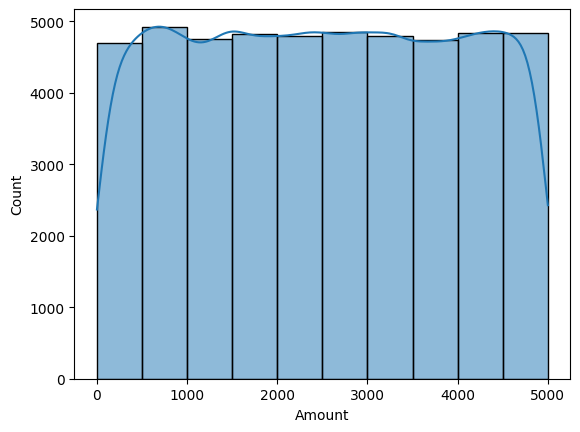

In [39]:
import seaborn as sns
sns.histplot(x=df['Amount'],bins=10, kde=True)   # check skew & spread
#sns.boxplot(x=df['Amount'])                     # visualize extreme outliers


<Axes: xlabel='Origin_Balance', ylabel='Count'>

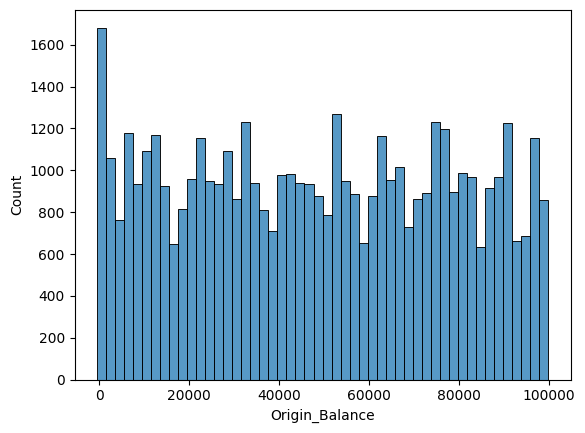

In [46]:
sns.histplot(df['Origin_Balance'],bins=50)

<Axes: xlabel='Amount_to_OriginBalance', ylabel='Count'>

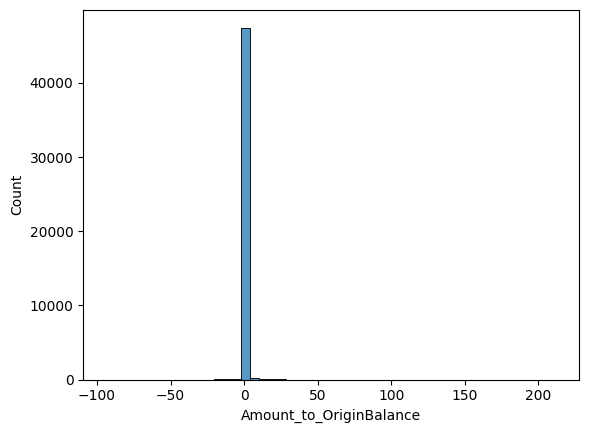

In [48]:
sns.histplot(df['Amount_to_OriginBalance'],bins=50)

<Axes: xlabel='Origin_Age', ylabel='Count'>

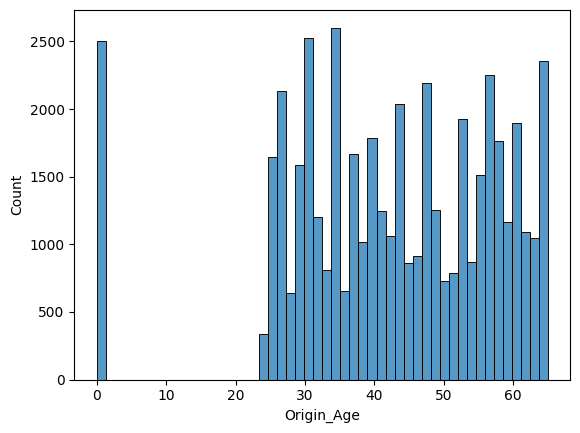

In [63]:
sns.histplot(df['Origin_Age'],bins=50)

<Axes: xlabel='Amount_to_OriginBalance'>

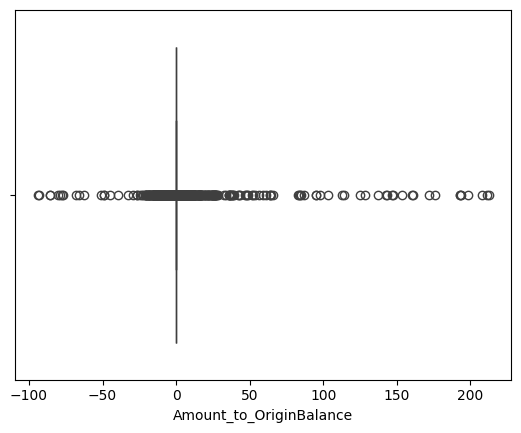

In [68]:
sns.boxplot(x=df['Amount_to_OriginBalance'])

In [ ]:
sns.boxplot(x=df['Origin_Age'])

<Axes: xlabel='Origin_Age'>

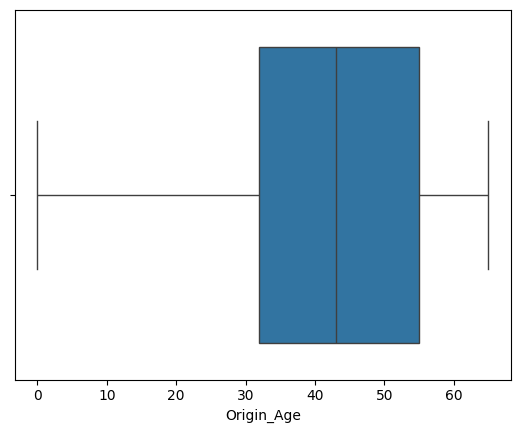

In [64]:
sns.boxplot(x=df['Origin_Age'])

<Axes: xlabel='Amount'>

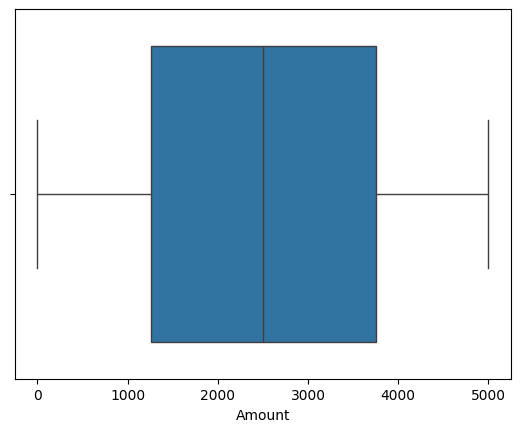

In [29]:
sns.boxplot(x=df['Amount'])

Categorical features:

<Axes: xlabel='TransactionTypeName'>

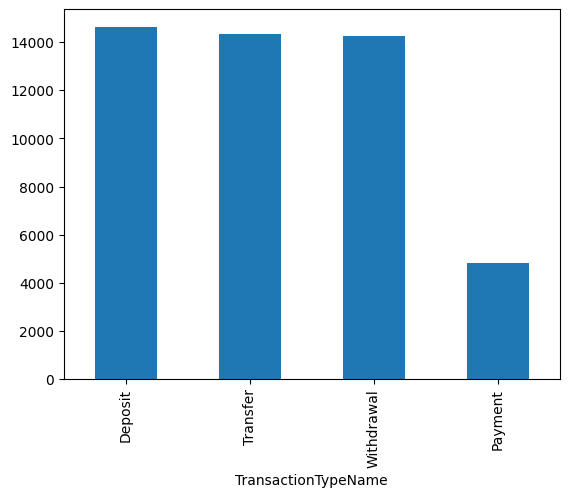

In [27]:
df['TransactionTypeName'].value_counts().plot(kind='bar')


<Axes: xlabel='Amount_to_DestBalance', ylabel='Amount'>

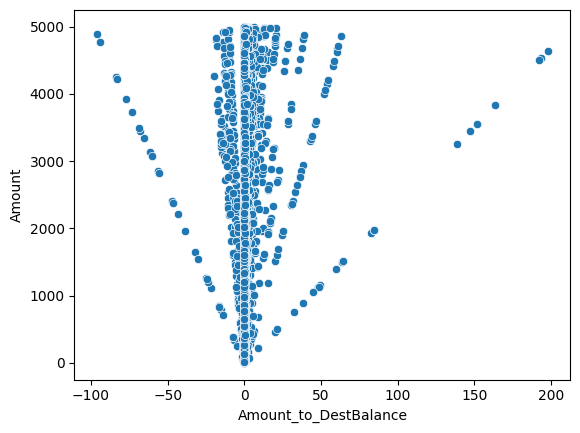

In [69]:
sns.scatterplot(x=df['Amount_to_DestBalance'], y='Amount', data=df)

<Axes: xlabel='Amount_to_OriginBalance', ylabel='Amount'>

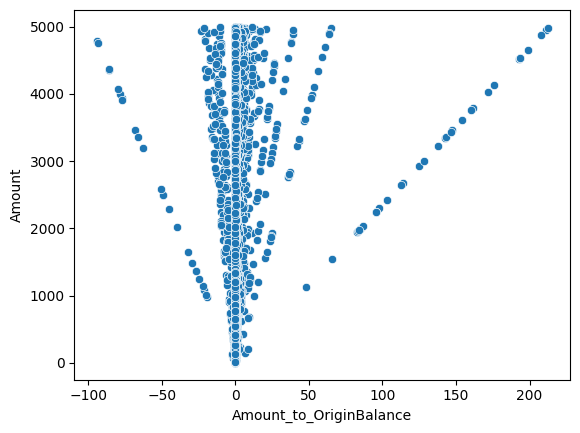

In [55]:
sns.scatterplot(x='Amount_to_OriginBalance', y='Amount', data=df)



<Axes: xlabel='Origin_Balance', ylabel='Origin_LoanLeverage'>

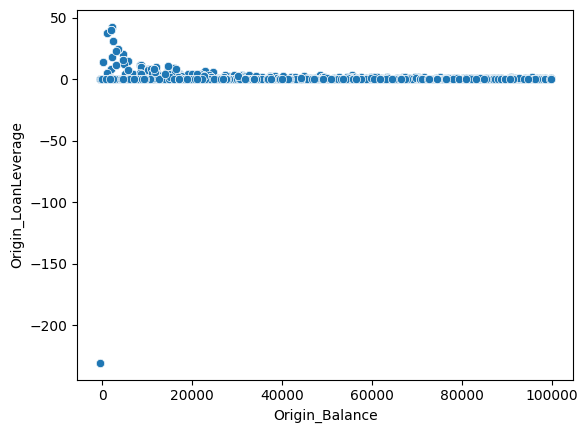

In [58]:
sns.scatterplot(x=df['Origin_Balance'],y=df['Origin_LoanLeverage'])

<Axes: xlabel='TransactionTypeName', ylabel='Amount'>

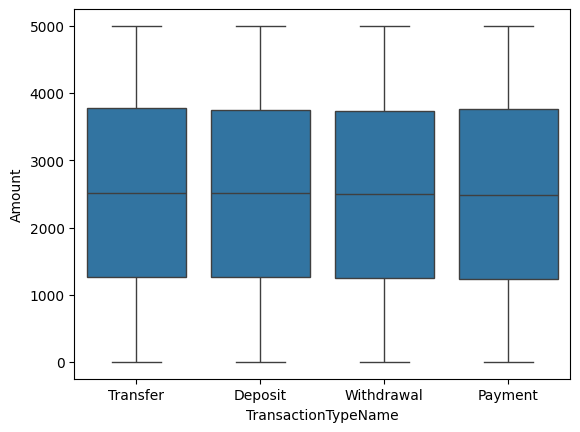

In [56]:
sns.boxplot(x='TransactionTypeName', y='Amount', data=df)

<Axes: xlabel='Origin_CustomerType', ylabel='Amount'>

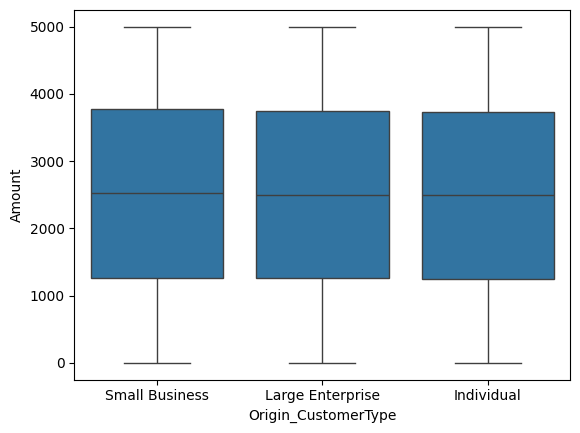

In [60]:
sns.boxplot(x=df['Origin_CustomerType'], y='Amount', data=df)

Step 5: Temporal Patterns

Goal: Detect unusual timing of transactions.

Use your engineered features:

TransactionHour, TransactionWeekday

For anomaly detection: transactions at unusual hours or weekdays may be flagged.

<Axes: xlabel='TransactionHour', ylabel='Count'>

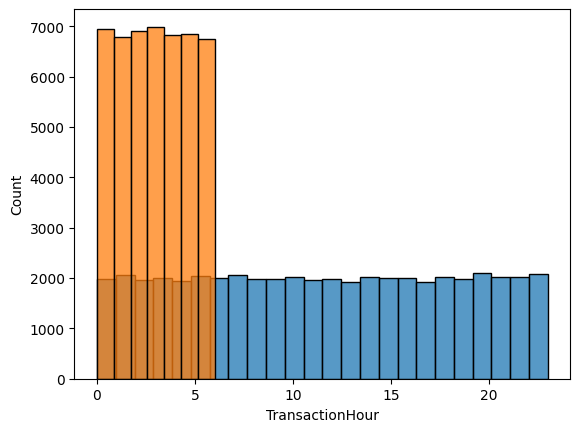

In [70]:
sns.histplot(df['TransactionHour'], bins=24)
sns.histplot(df['TransactionWeekday'], bins=7)


Step 6: Feature Correlation & Redundancy

Goal: Avoid feeding redundant features to unsupervised models.

Identify:

Highly correlated features (e.g., Balance vs Amount_to_Balance) → keep one.

<Axes: >

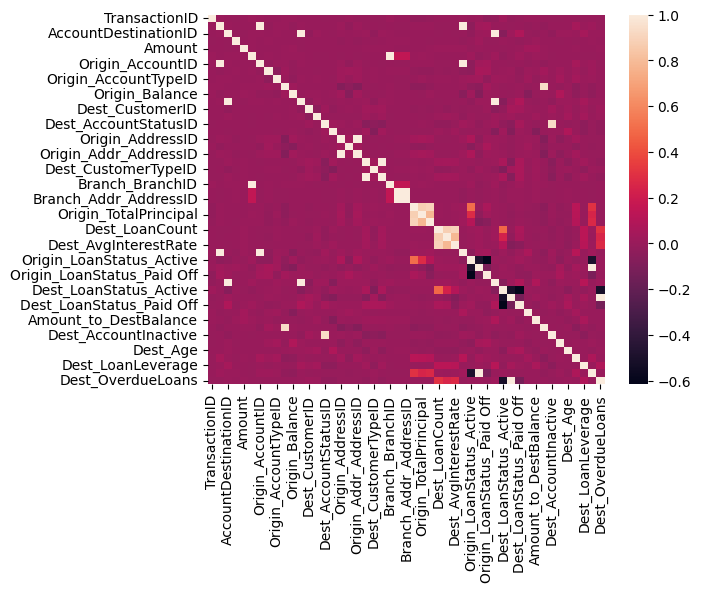

In [73]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=False)

In [91]:
# Keep only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlation on numeric features only
corr_matrix = numeric_df.corr().abs()

# Drop redundant features with high correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
to_keep = [col for col in numeric_df.columns if col not in to_drop]
print("Drop these features:", to_drop)
print("Keep these features:", to_keep)


Drop these features: ['Origin_AccountID', 'Dest_AccountID', 'Origin_Addr_AddressID', 'Dest_Addr_AddressID', 'Branch_BranchID', 'Branch_Addr_AddressID', 'Origin_TotalPrincipal', 'Origin_AvgInterestRate', 'Dest_TotalPrincipal', 'Dest_AvgInterestRate', 'Origin_LoanStatus_AccountID', 'Dest_LoanStatus_AccountID', 'Origin_AccountInactive', 'Dest_AccountInactive', 'Origin_OverdueLoans', 'Dest_OverdueLoans']
Keep these features: ['TransactionID', 'AccountOriginID', 'AccountDestinationID', 'TransactionTypeID', 'Amount', 'BranchID', 'Origin_CustomerID', 'Origin_AccountTypeID', 'Origin_AccountStatusID', 'Origin_Balance', 'Dest_CustomerID', 'Dest_AccountTypeID', 'Dest_AccountStatusID', 'Dest_Balance', 'Origin_AddressID', 'Origin_CustomerTypeID', 'Dest_AddressID', 'Dest_CustomerTypeID', 'Branch_AddressID', 'Origin_LoanCount', 'Dest_LoanCount', 'Origin_LoanStatus_Active', 'Origin_LoanStatus_Overdue', 'Origin_LoanStatus_Paid Off', 'Dest_LoanStatus_Active', 'Dest_LoanStatus_Overdue', 'Dest_LoanStatus_

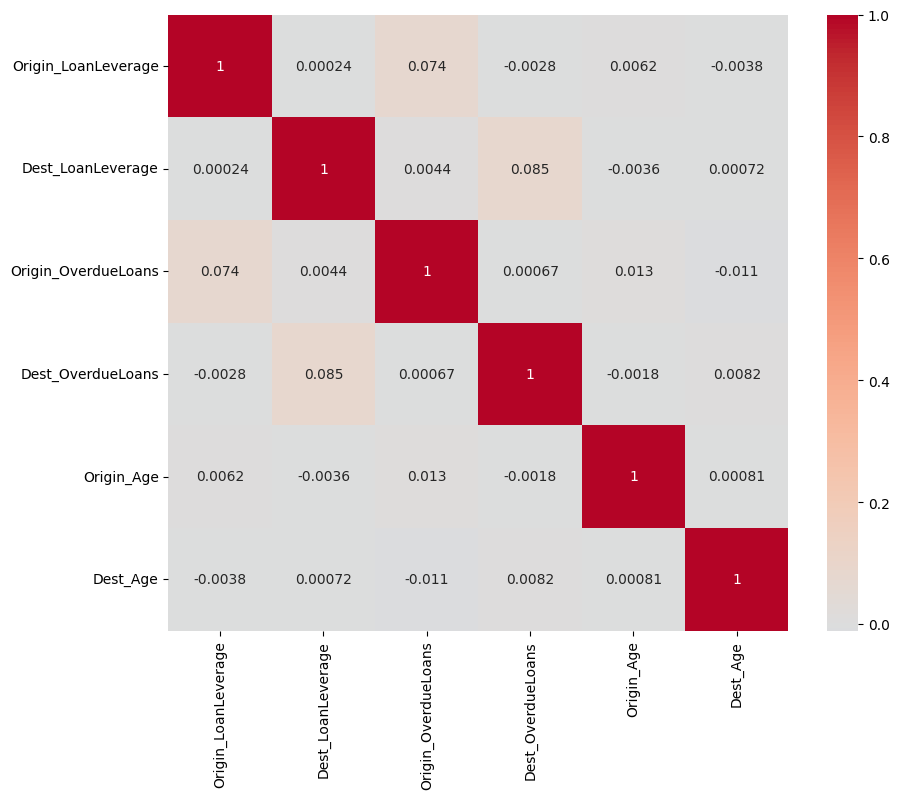

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only select candidate numeric features for anomaly detection
features = ['Origin_LoanLeverage','Dest_LoanLeverage',
            'Origin_OverdueLoans','Dest_OverdueLoans',
            'Origin_Age','Dest_Age']

plt.figure(figsize=(10,8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', center=0)
plt.show()

In [ ]:
df['Origin_Balance']

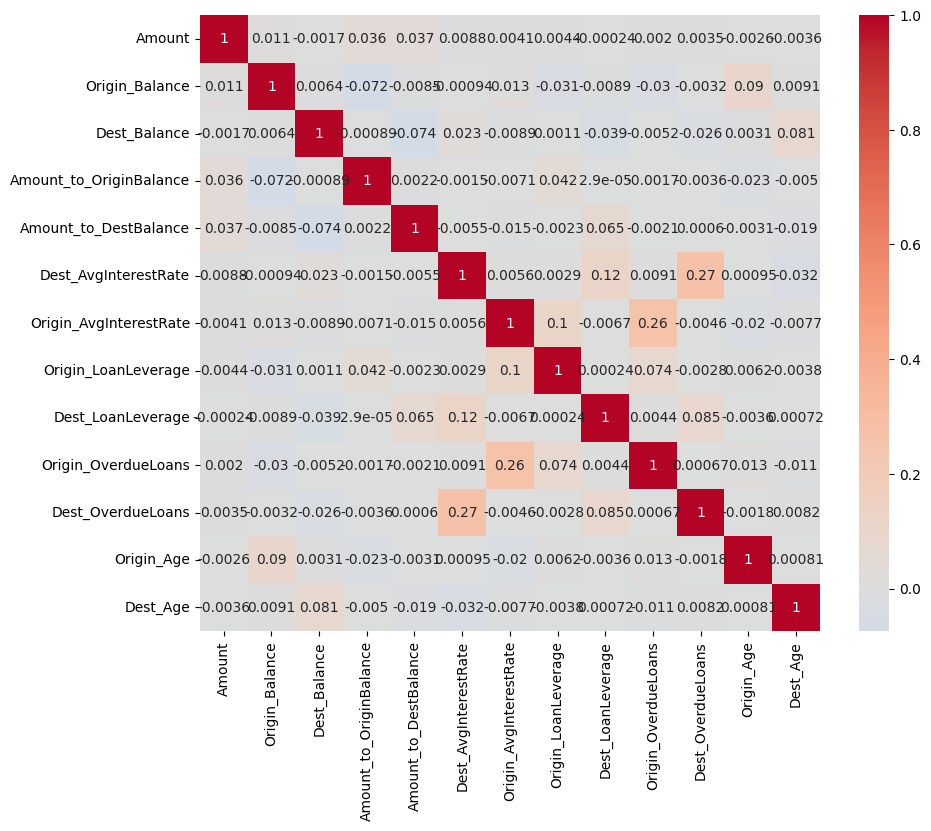

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only select candidate numeric features for anomaly detection
features = ['Amount','Origin_Balance','Dest_Balance', 'Amount_to_OriginBalance', 'Amount_to_DestBalance','Dest_AvgInterestRate',
            'Origin_AvgInterestRate','Origin_LoanLeverage','Dest_LoanLeverage',
            'Origin_OverdueLoans','Dest_OverdueLoans',
            'Origin_Age','Dest_Age']

plt.figure(figsize=(10,8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', center=0)
plt.show()


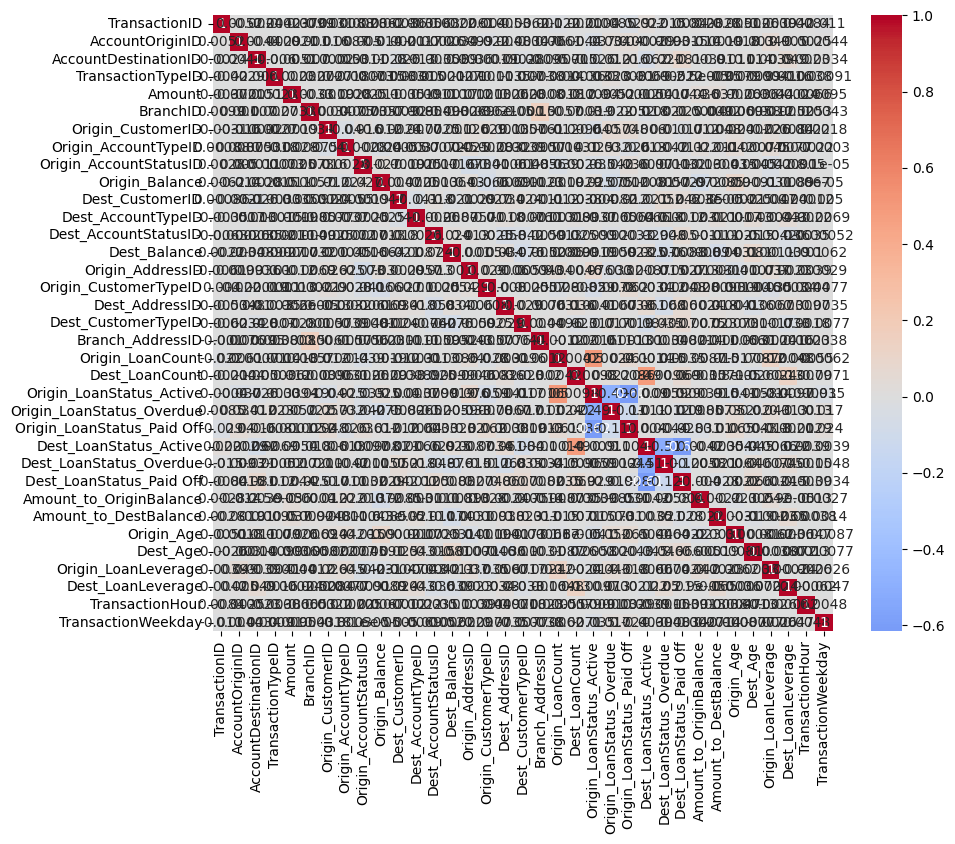

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only select candidate numeric features for anomaly detection
features = to_keep

plt.figure(figsize=(10,8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', center=0)
plt.show()

<Axes: xlabel='Origin_CustomerType', ylabel='Amount_to_OriginBalance'>

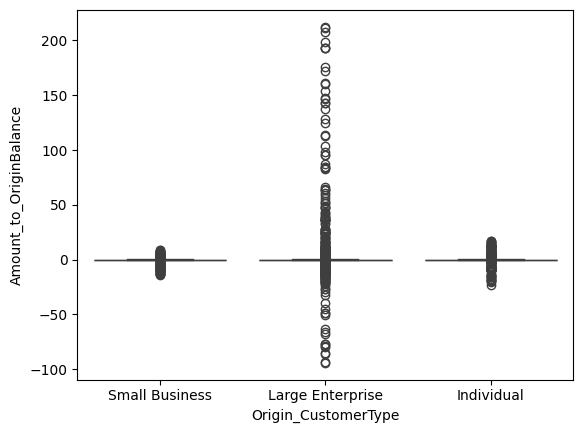

In [77]:
#sns.histplot(df['Amount_to_OriginBalance'], bins=50)
sns.boxplot(x='Origin_CustomerType', y='Amount_to_OriginBalance', data=df)


In [ ]:
# Final refined feature set
keep_features = [
    "Amount",
    "Origin_Balance",
    "Dest_Balance",
    "Origin_LoanCount",
    "Dest_LoanCount",
    "Origin_LoanStatus_Active",
    "Origin_LoanStatus_Overdue",
    "Origin_LoanStatus_Paid Off",
    "Dest_LoanStatus_Active",
    "Dest_LoanStatus_Overdue",
    "Dest_LoanStatus_Paid Off",
    "Amount_to_OriginBalance",
    "Amount_to_DestBalance",
    "Origin_Age",
    "Dest_Age",
    "Origin_LoanLeverage",
    "Dest_LoanLeverage",
    "TransactionHour",
    "TransactionWeekday"
]

# Keep only these columns
df_model = df[keep_features].copy()

print("Shape after feature selection:", df_model.shape)
print(df_model.head())


Shape after feature selection: (48042, 19)
    Amount  Origin_Balance  Dest_Balance  Origin_LoanCount  Dest_LoanCount  \
0  2984.02        55292.55      54095.48               1.0             0.0   
1  4713.48        22940.53      70727.24               2.0             1.0   
2  1600.23        62435.08      90061.73               1.0             0.0   
3  4279.61        12739.44      32623.75               1.0             1.0   
4  4125.32        56605.54          0.00               1.0             0.0   

   Origin_LoanStatus_Active  Origin_LoanStatus_Overdue  \
0                       0.0                        1.0   
1                       2.0                        0.0   
2                       1.0                        0.0   
3                       1.0                        0.0   
4                       1.0                        0.0   

   Origin_LoanStatus_Paid Off  Dest_LoanStatus_Active  \
0                         0.0                     NaN   
1                        

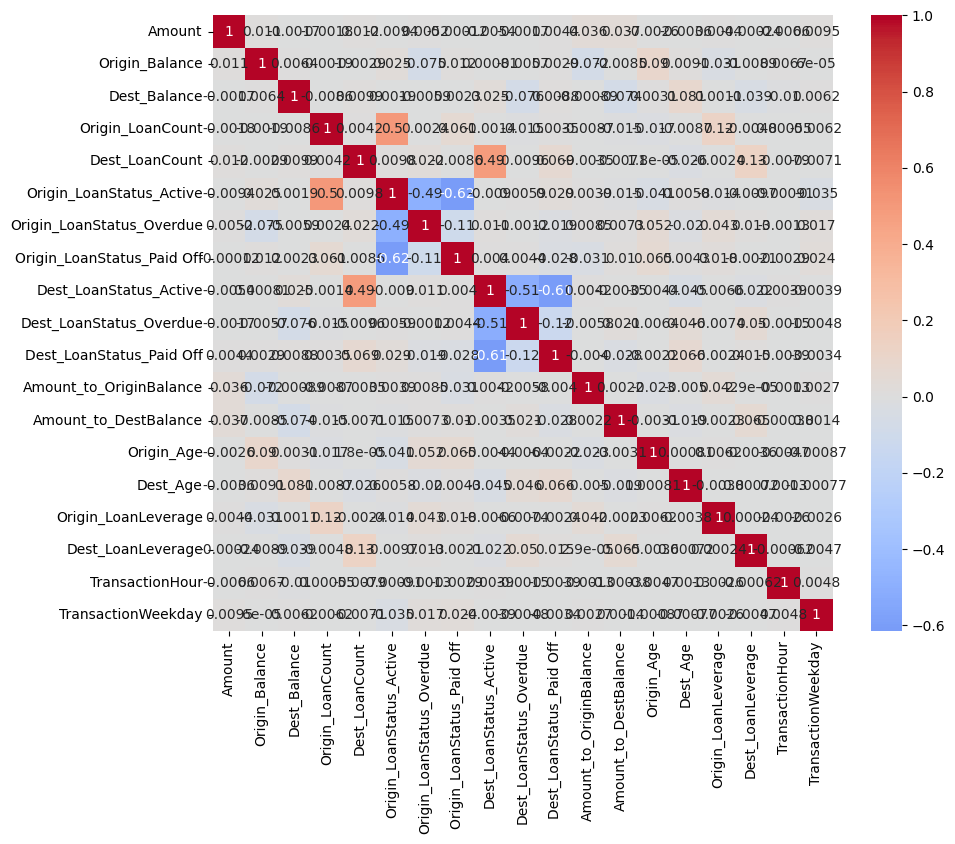

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only select candidate numeric features for anomaly detection
features = keep_features

plt.figure(figsize=(10,8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', center=0)
plt.show()